In [1]:
from IPython.display import display, Math, Latex

# Supervised Learning as a possible solution to RFI Flagging

***Supervised learning*** is one of the main three types of machine learning along with unsupervised learning and reinforcement learning.

Supervised learning involves modelling the relationship between input *X* and outputs *Y*, where *X* can be the features space of a given dataset and *Y* could be some label. The model is determined by showing some machine learning algorithm examples of the input *X* and the corresponding *Y* output for a function: 
$$ F: X → Y$$
so that given an unseen observation $x$, $F(x)$ can confidently predict the corresponding output $y$.

Supervised learning can be further explained through Classification or Regression, were in *classification*, the labels are discrete categories, while in *regression*, the labels are continuous quantities.

In this notebook, I will be presenting the work that I have done investigating whether or not supervised machine learning algorithms can be used to flag RFI

In [2]:
#Standard utilities
import itertools
import glob
import numpy as np
import pandas as pd
from pyrap.tables import table
from collections import Counter

# Supervised Machine learning algorithms used

### k-nearest neighbour classifier

The first algorithm to be mentioned is the k-nearest neighbour classifier, which is **non-parametric** and it is an **instant based** algorithm.

- *Non-parametric* means it makes no explicit assumptions about the functional form of F, avoiding the dangers of mismodeling the underlying distribution of the data.

- *Instance-based* learning means that our algorithm doesn’t explicitly learn a model. Instead, it chooses to memorize the training instances which are subsequently used as “knowledge” for the prediction phase. 



The K-nearest neighbor algorithm essentially boils down to forming a majority vote between the K most similar instances to a given “unseen” observation. Similarity is defined according to a distance metric between two data points. A popular choice is the Euclidean distance given by
$$d(x,x') = \sqrt{(x_{1} - x'_{1})^{2} + (x_{2} - x'_{2})^{2} +...+ (x_{n} - x'_{n})^{2} } $$

but other measures can be more suitable for a given setting and include the Manhattan, Chebyshev and Hamming distance.

More formally, given a positive integer K, an unseen observation x and a similarity metric dd, KNN classifier performs the following two steps:

- It runs through the whole dataset computing dd between $x$ and each training observation. We’ll call the K points in the training data that are closest to $x$ the set X.

- It then estimates the conditional probability for each class, that is, the fraction of points in X with that given class label. 

$$P(y = j|X = x) = \frac{1}{K} \sum_{i → X}I(y^{i} = j) $$

where $I(x)$ is the indicator function which evaluates to 1 when the argument $x$ is true and 0 otherwise.

Finally, our input $x$ gets assigned to the class with the largest probability. An alternate way of understanding KNN is by thinking about it as calculating a decision boundary.



like most machine learning algorithms, the K in KNN is a hyperparameter that you, as a designer, must pick in order to get the best possible fit for the data set. Intuitively, you can think of K as controlling the shape of the decision boundary we talked about earlier.

When K is small, we are restraining the region of a given prediction and forcing our classifier to be “more blind” to the overall distribution. A small value for K provides the most flexible fit, which will have low bias but high variance. Graphically, our decision boundary will be more jagged.

On the other hand, a higher K averages more voters in each prediction and hence is more resilient to outliers. Larger values of K will have smoother decision boundaries which means lower variance but increased bias.



### Naive Bayes Classifier

Naive bayes is a relatively simple probabilistic classfication algorithm that is well suitable for categorical data (probabilities can be compuated as simple ratios) and uses the bayes theorem together with a strong independence assumption. The basic idea behind Naive Bayes is that it assigns a probability to every category (finite outcome variable) based on the features in the data and chooses the outcome that is most likely as its prediction.

The "Naive" in the name refers to the algorithm assuming features in the data are independent conditional on the outcome category. For example in RFI classification, then given a dataset "0 (Clean), 1 (RFI)", Naive Bayes would assume "0", "1" all occur indepedently of each other (that is $P(0, 1|RFI)$ = $P(0|RFI)\times P(1|RFI)$). This conditional independence assumption is considered to be a strong assumption that often doesn't hold in practice, hence the resulting probabilities from Naive Bayes are not to be taken too seriously. However the classifications resulting from Naive Bayes can still be accurate.

In machine learning, common application of Naive Bayes are spam email classification, sentiment analysis, document categorization. Naive bayes is advantageous over other commonly used classification algorithms in its simplicity, speed, and its accuracy on small data sets. Since Naive Bayes needs to be trained on a labeled data set it considered to a supervisd learning algorithm.

Suppose we have a data set where each observation $i$ belongs to a category from the finite set $Y_{i} = \{y_{1i},y_{2i},\ldots, y_{ni}\},$ and consists of several features $X_{i} = \{x_{1i},\ldots,x_{mi}\}.$ If we could find probabilities $P(y_{1i}|X_{i}), P(y_{2i}|X_{i}), \ldots, P(y_{ni}|X_{i}),$ then we could predict the label for observation $i$ to be the one that has the highest probability.

To compute conditional probabilities, we can use the Bayes theorem from statistics which says, 
$$P(y_{ji}|X_{i}) = \frac{P(y_{ji} \text{ and } X_{i})}{P(X_{i})} = \frac{P(X_{i}|y_{ji})P(y_{ji})}{P(X_{i})},$$ 

where $j = 1, 2, \ldots, n.$ Usually $P(X_{i})$ and $P(y_{ji})$ are either well known, or can be estimated easily from the data. However $P(X_{i}|y_{ji})$ is a another conditional probability that we need to find and using Bayes rule again will not help here. This is were the "Naive" part steps in, we assume that the data features $x_{1i}, x_{2i}, \ldots, x_{mi}$ are all independent of each other conditional on knowing the class $y_{ji}.$ Statistically that means 

$$P(X_{i}|y_{ji}) = P(x_{1i}, x_{2i}, \ldots, x_{mi}|y_{ji}) = P(x_{1i}|y_{ji})P(x_{2i}|y_{ji}) \ldots P(x_{mi}|y_{ji}).$$ 

Given this result from the "Naive" assumption of conditional indepdence, we can compute 

$$P(y_{ji}|X_{i}) = \frac{P(X_{i}|y_{ji})P(y_{ji})}{P(X_{i})} = \frac{P(x_{1i}|y_{ji})P(x_{2i}|y_{ji}) \ldots P(x_{mi}|y_{ji})P(y_{ji})}{P(X_{i})}.$$

In many problems we can find $P(x_{li}|y_{ji})$ for $l = 1,\ldots,m$ by using 

$$P(x_{li}|y_{ji}) = \frac{P(x_{li} \text{ and } y_{ji})}{P(y_{ji})}.$$ 

Therefore we can find the probability of each class occuring given features in the data, $P(y_{1i}|X_{i}),P(y_{2i}|X_{i}), \ldots, P(y_{ni}|X_{i}).$ Next we can just compare all of these probabilities to each other, and pick the class that is most likely. Also note that we can omit $P(X_{i})$ in the denominator above because it is common to all the conditional class probabilities and will not effect their rankings, that is if 

\begin{eqnarray}
\frac{P(x_{1i}|y_{1i}) \ldots P(x_{mi}|y_{1i})P(y_{1i})}{P(X_{i})} &\gt& \frac{P(x_{1i}|y_{2i}) \ldots P(x_{mi}|y_{2i})P(y_{2i})}{P(X_{i})} \implies \\
P(x_{1i}|y_{1i}) \ldots P(x_{mi}|y_{1i})P(y_{1i}) &\gt& P(x_{1i}|y_{2i}) \ldots P(x_{mi}|y_{2i})P(y_{2i})
\end{eqnarray}

The Naive Bayes classifier combines this model with a decision rule, this decision rule will decide which hypothesis is most probable, in our example case this will be which class of flower is most probable.
Picking the hypothesis that is most probable is known as the maximum a posteriori or MAP decision rule. The corresponding classifier, a Bayes classifier, is the function that assigns a class label to y as follows:
Since $P(x_{1i}, ..., x_{mi}$) is constant given the input, we can use the following classification rule: 

$$P(y_{ji} \mid x_{1i}, \dots, x_{mi}) \propto P(y_{ji}) \prod_{j=1}^{m} P(x_{ji} \mid y_{ji})$$

$$\Downarrow$$$$\hat{y} = \arg\max_y P(y_{ji}) \prod_{j=1}^{n} P(X_i \mid y_{ji}),$$

and we can use Maximum A Posteriori (MAP) estimation to estimate $P(y_{ji})$ and $P(X_i | y_{ji})$; the former is then the relative frequency of class y in the training set.
There are different naive Bayes classifiers that differ mainly by the assumptions they make regarding the distribution of $P(X_i | y_{ji}$).


### Random Forest Classifier

Decision tree is a supervised learning algorithm. It works for both categorical and continuous input (features) and output (predicted) variables. Tree-based methods partition the feature space into a set of rectangles, and then fit a simple model (like a constant) in each one. They are conceptually simple yet powerful.





In [3]:
#Machine Learinging Classifiers
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [4]:
#Preprocessing
from sklearn import preprocessing
from sklearn.utils import shuffle
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import normalize
from sklearn.cross_validation import train_test_split # Data splitting

/data/olorato/mywork/local/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [5]:
#Performance Measures
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score,matthews_corrcoef
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report,accuracy_score,confusion_matrix


#Feature Selection
from skfeature.function.similarity_based import fisher_score
from skfeature.function.similarity_based import reliefF
from skfeature.function.statistical_based import CFS


#plotting
import seaborn as sns
import matplotlib as mpl
from mlxtend.plotting import plot_learning_curves
from mlxtend.plotting import plot_decision_regions
sns.set_context('paper',font_scale=2.0)
sns.set_style("whitegrid")
palette = sns.plt.cm.gray_r
# set masked values to plot red
palette.set_bad('r', 1.0)

In [6]:
def roc_plot(classifiers,subplot,model_names):
    #c = ['r','g','b']
    if subplot == True:
        num = len(classifiers)
        sns.plt.figure()
        for i in range(num):
            sns.plt.subplot(1,num,i+1)
            clf = classifiers[i]
            y_roy_fpr, y_roy_tpr, y_roy_thresholds = roc_curve(y_test0, clf[:,1])
            sns.plt.plot(y_roy_fpr, y_roy_tpr,label=model_names[i]+' AUC = %0.2f'% auc(y_roy_fpr, y_roy_tpr))
            sns.plt.legend(loc='lower right')
            sns.plt.plot([0,1],[0,1],'r--')
            sns.plt.xlim([-0.1,1.2])
            sns.plt.ylim([-0.1,1.2])
            sns.plt.ylabel('True Positive Rate')
            sns.plt.xlabel('False Positive Rate')
    if subplot == False:
        num = len(classifiers)
        sns.plt.figure()
        for i in range(num):
            clf = classifiers[i]
            y_roy_fpr, y_roy_tpr, y_roy_thresholds = roc_curve(y_test0, clf[:,1])
            sns.plt.plot(y_roy_fpr, y_roy_tpr,label=model_names[i]+' AUC = %0.2f'% auc(y_roy_fpr, y_roy_tpr))
            sns.plt.legend(loc='lower right')
            sns.plt.plot([0,1],[0,1],'r--')
            sns.plt.xlim([-0.1,1.2])
            sns.plt.ylim([-0.1,1.2])
            sns.plt.ylabel('True Positive Rate')
            sns.plt.xlabel('False Positive Rate')
    return

In [7]:
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=sns.plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    sns.plt.imshow(cm, interpolation='nearest', cmap=cmap)
    #sns.plt.title(title)
    #sns.plt.colorbar()
    tick_marks = np.arange(len(classes))
    sns.plt.xticks(tick_marks, classes, rotation=45)
    sns.plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        pass
        #print('Confusion matrix, without normalization')

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            sns.plt.text(j, i, round(cm[i, j],2),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            sns.plt.text(j, i, cm[i, j],
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
    sns.plt.tight_layout()
    sns.plt.grid(False)
    sns.plt.ylabel('True label')
    sns.plt.xlabel('Predicted label')

In [8]:
def evaluate(model,modelname):
    print('====================================================')
    print('Classification Report for %s'%modelname)
    print('====================================================')
    print(classification_report(y_test0,model,target_names=['Not RFI','RFI']))

    print('\n The model is %f accurate' %(accuracy_score(y_test0,model)*100))
    print('====================================================\n\n')

In [9]:
def report(results,num, n_top=3):
    #n_top = len(results['rank_test_score']) -1
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

## retriving all of the datasets

In [10]:
#data_files = shuffle(glob.glob("HH13*pks1613*csv"),random_state=3) # use for Playing around
data_files = ["HH1333134985_pks1613-586.1822.ms_all_data_baseline1and5.csv",
"HH1333305511_pks1613-586.1822.ms_all_data_baseline1and5.csv",] # use to reproduce the my Results
print data_files

['HH1333134985_pks1613-586.1822.ms_all_data_baseline1and5.csv', 'HH1333305511_pks1613-586.1822.ms_all_data_baseline1and5.csv']


In [11]:
#names of the features
names = ["d_p","tC_mean","tp_mean",'t_skew','t_kurtosis','t_cumsumx','t_sumvalues'
         ,'t_slope','t_per25','t_per75','t_var',"fC_mean","fp_mean",'f_skew'
         ,'f_kurtosis','f_cumsumx','f_sumvalues','f_slope','f_per25','f_per75','f_var']
target_names = ['Not RFI','RFI']
#getting feature pairs for plotting
pairs = list(itertools.combinations(names,2))
len(pairs)

210

In [12]:
#selecting datasets to use for Training
data_names =[]
datasets = []
for filename in shuffle(data_files[0:2],random_state=4):
    data = pd.DataFrame.from_csv(filename)
    if len(np.where(data["rfi"].values == 1)[0])/float(len(data["rfi"])) < 0.4:       
        datasets.append(data)
        print filename
        data_names.append(filename)
    del data
X0 = pd.concat(datasets, ignore_index=True)
del datasets

HH1333305511_pks1613-586.1822.ms_all_data_baseline1and5.csv
HH1333134985_pks1613-586.1822.ms_all_data_baseline1and5.csv


/data/olorato/mywork/local/lib/python2.7/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


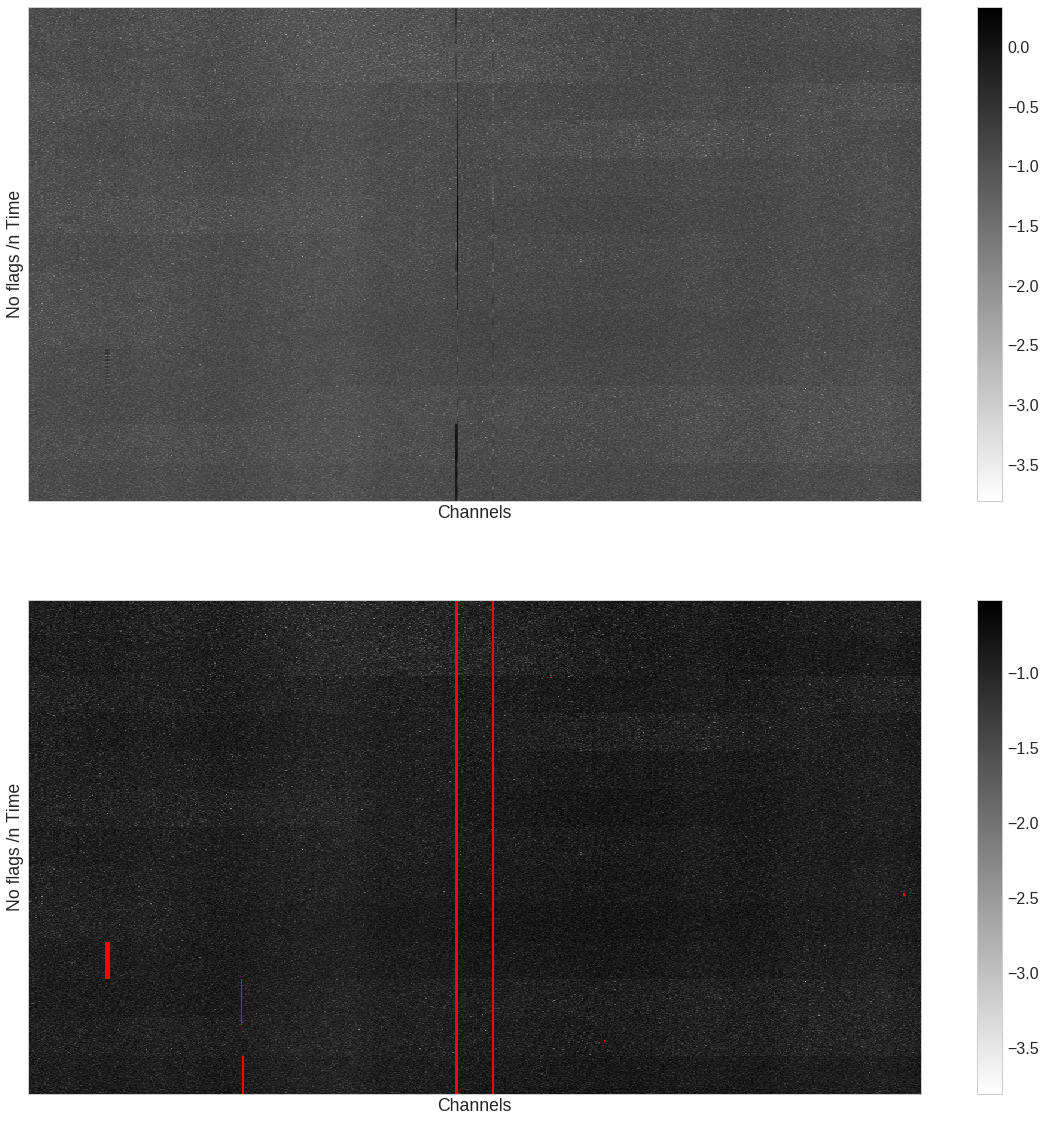

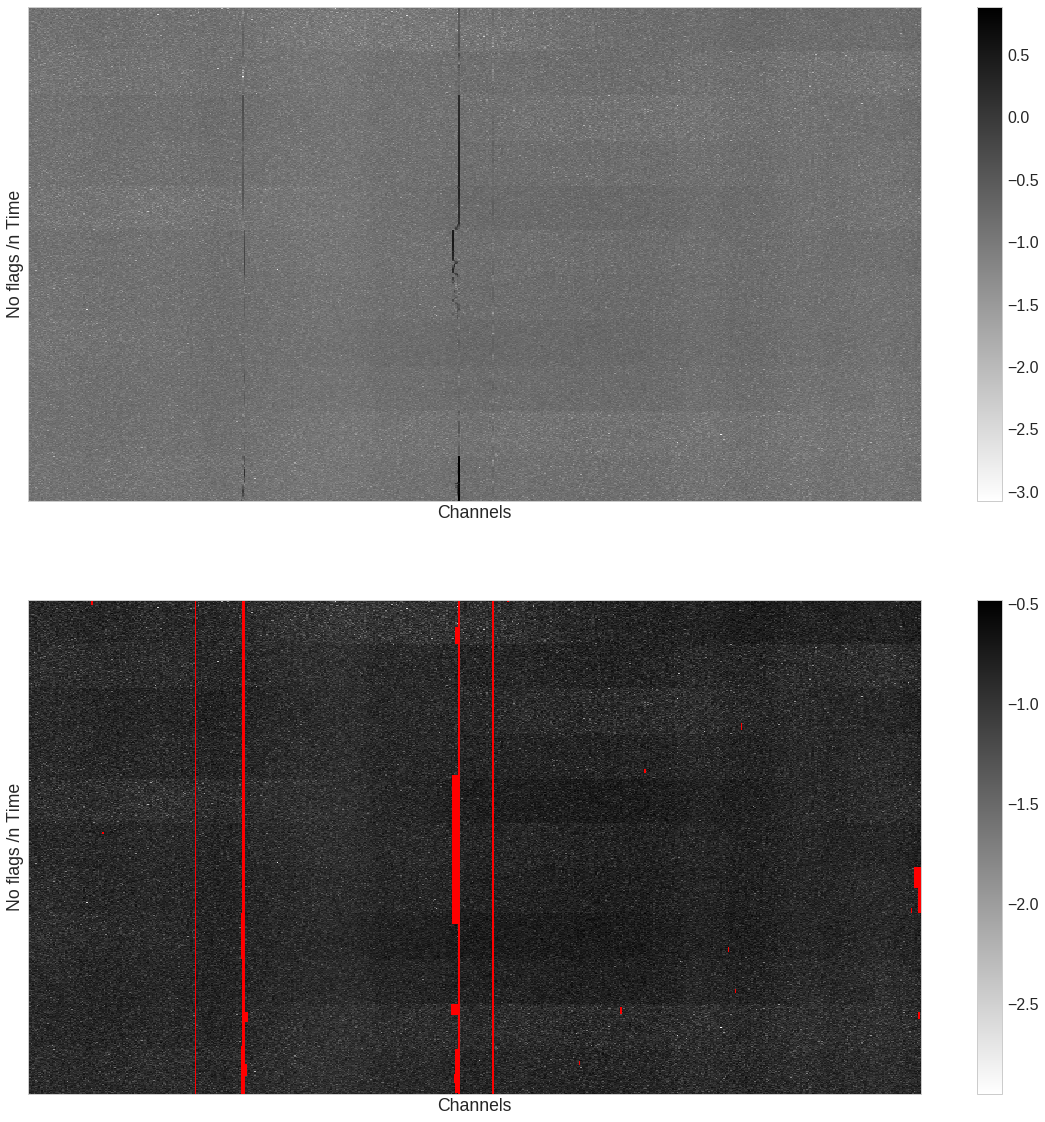

In [13]:
for i in data_names:    
    testVV = pd.DataFrame.from_csv(i)
    image = np.reshape(testVV['d_p'],(len(testVV)/len(np.unique(testVV['frequency'])),len(np.unique(testVV['frequency']))), order='F' )
    org_flags = np.reshape(testVV['rfi'],(len(testVV)/len(np.unique(testVV['frequency'])),len(np.unique(testVV['frequency']))), order='F')

    sns.plt.figure(figsize=(20,20))
    sns.plt.subplot(2,1,1)
    sns.plt.imshow(np.log10(image),cmap=palette,aspect ='auto')
    sns.plt.grid(False)
    sns.plt.colorbar()
    sns.plt.xlabel("Channels")
    sns.plt.ylabel("No flags /n Time")
    sns.plt.xticks([])
    sns.plt.yticks([])
    sns.plt.subplot(2,1,2)
    sns.plt.imshow(np.log10(np.ma.array(image,mask=org_flags)),cmap=palette,aspect ='auto')
    sns.plt.grid(False)
    sns.plt.colorbar()
    sns.plt.xlabel("Channels")
    sns.plt.ylabel("No flags /n Time")
    sns.plt.xticks([])
    sns.plt.yticks([])
    sns.plt.show()


In [14]:
X0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 858600 entries, 0 to 858599
Data columns (total 25 columns):
ant1           858600 non-null int64
ant2           858600 non-null int64
d_p            858600 non-null float64
fC_mean        858600 non-null float64
f_cumsumx      858600 non-null float64
f_kurtosis     858600 non-null float64
f_per25        858600 non-null float64
f_per75        858600 non-null float64
f_skew         858600 non-null float64
f_slope        858600 non-null float64
f_sumvalues    858600 non-null float64
f_var          858600 non-null float64
fp_mean        858600 non-null float64
frequency      858600 non-null int64
rfi            858600 non-null int64
tC_mean        858600 non-null float64
t_cumsumx      858600 non-null float64
t_kurtosis     858600 non-null float64
t_per25        858600 non-null float64
t_per75        858600 non-null float64
t_skew         858600 non-null float64
t_slope        858600 non-null float64
t_sumvalues    858600 non-null float64


In [15]:
X0.describe()

ant1      ant2            d_p        fC_mean      f_cumsumx  \
count  858600.0  858600.0  858600.000000  858600.000000  858600.000000   
mean        1.0       5.0       0.131583       0.139358       1.823293   
std         0.0       0.0       0.078543       0.007633       5.245187   
min         1.0       5.0       0.000156       0.114687       0.004913   
25%         1.0       5.0       0.103718       0.133885       1.048432   
50%         1.0       5.0       0.128877       0.139384       1.164668   
75%         1.0       5.0       0.155164       0.145497       1.293779   
max         1.0       5.0       7.645745       0.157057      48.972252   

          f_kurtosis        f_per25        f_per75         f_skew  \
count  858600.000000  858600.000000  858600.000000  858600.000000   
mean       -0.487131       0.108104       0.147347       0.084237   
std         1.016169       0.025201       0.029927       0.693780   
min        -1.930759       0.000079       0.000577      -2.417254   
25%        -1.117724       0.094733       0.132928      -0.349429   
50%        -0.744098       0.108703       0.148205       0.038212   
75%        -0.194281       0.123267       0.164088       0.441621   
max         4.125003       0.218272       0.927413       2.474874   

             f_slope      ...              tC_mean      t_cumsumx  \
count  858600.000000      ...        858600.000000  858600.000000   
mean        2.128891      ...             0.131583       1.184238   
std        92.537184      ...             0.036366       0.629413   
min     -6385.982866      ...             0.099905       0.404785   
25%       -20.826395      ...             0.120595       1.046904   
50%        -0.095617      ...             0.130305       1.160397   
75%        21.067533      ...             0.138277       1.283031   
max     13495.875307      ...             1.247802      67.134918   

          t_kurtosis        t_per25        t_per75         t_skew  \
count  858600.000000  858600.000000  858600.000000  858600.000000   
mean       -0.605542       0.111491       0.151461       0.016458   
std         0.732110       0.067983       0.076202       0.589713   
min        -1.946104       0.013927       0.054986      -2.448727   
25%        -1.127981       0.095672       0.133719      -0.366567   
50%        -0.766912       0.109243       0.148552       0.014864   
75%        -0.260093       0.123668       0.164410       0.396666   
max         4.116393       7.443395       7.532206       2.471817   

             t_slope    t_sumvalues          t_var        tp_mean  
count  858600.000000  858600.000000  858600.000000  858600.000000  
mean        0.011387       1.184238       0.001266       0.131582  
std        32.878014       0.629413       0.025430       0.069935  
min      -256.648894       0.404785       0.000022       0.044976  
25%       -21.763066       1.046904       0.000655       0.116323  
50%         0.074422       1.160397       0.000966       0.128933  
75%        21.780353       1.283031       0.001374       0.142559  
max       387.417470      67.134918       9.800971       7.459435  

[8 rows x 25 columns]

In [16]:
X0.head()

ant1  ant2       d_p   fC_mean  f_cumsumx  f_kurtosis   f_per25   f_per75  \
0     1     5  0.080836  0.124693  38.950191    4.125001  0.000559  0.001358   
1     1     5  0.143090  0.124693   1.020490   -1.589251  0.081635  0.147104   
2     1     5  0.082413  0.125394  40.486519    4.125000  0.000852  0.001276   
3     1     5  0.095210  0.125394   1.062093    0.325011  0.111901  0.127087   
4     1     5  0.080819  0.125478  40.642002    4.124999  0.000451  0.000751   

     f_skew    f_slope    ...      tC_mean  t_cumsumx  t_kurtosis   t_per25  \
0  2.474874  -0.115560    ...     0.116443   0.970764   -0.723232  0.082413   
1  0.155227 -19.563734    ...     0.116443   0.970764   -0.723232  0.082413   
2  2.474874  -0.111172    ...     0.116443   0.970764   -0.723232  0.082413   
3 -0.751022 -48.614274    ...     0.116443   0.970764   -0.723232  0.082413   
4  2.474874  -0.110739    ...     0.116443   0.970764   -0.723232  0.082413   

    t_per75    t_skew    t_slope  t_sumvalues     t_var   tp_mean  
0  0.121821  0.778227  16.813853     0.970764  0.000768  0.107863  
1  0.121821  0.778227  16.813853     0.970764  0.000768  0.107863  
2  0.121821  0.778227  16.813853     0.970764  0.000768  0.107863  
3  0.121821  0.778227  16.813853     0.970764  0.000768  0.107863  
4  0.121821  0.778227  16.813853     0.970764  0.000768  0.107863  

[5 rows x 25 columns]

In [17]:
print("Following is a breakup of RFI Class. 1 means RFI, 0 means not RFI(clean data).")
print(X0['rfi'].value_counts())

Following is a breakup of RFI Class. 1 means RFI, 0 means not RFI(clean data).
0    851189
1      7411
Name: rfi, dtype: int64


# Exploratory Data Analysis
###  Histograms of various features by RFI class

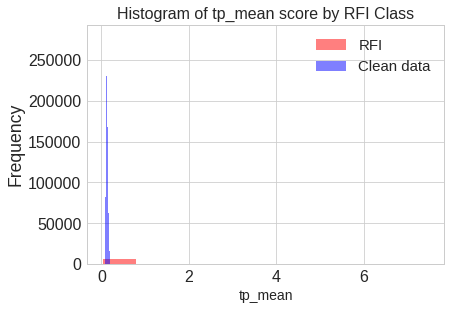

In [18]:
sns.plt.figure()
X0[X0['rfi']==1][names[2]].plot.hist(alpha=0.5,color='red', label='RFI')
X0[X0['rfi']==0][names[2]].plot.hist(alpha=0.5, color='blue', label='Clean data')

sns.plt.legend(fontsize=15)
sns.plt.title ("Histogram of "+str(names[2])+" score by RFI Class", fontsize=16)
sns.plt.xlabel(names[2], fontsize=14)
sns.plt.show()

from the image above one can see that the clean data seem to be concentrated around some small region in the feature space. When it comes to RFI the region in which RFI lies is more spread out around and away from the region of clean data

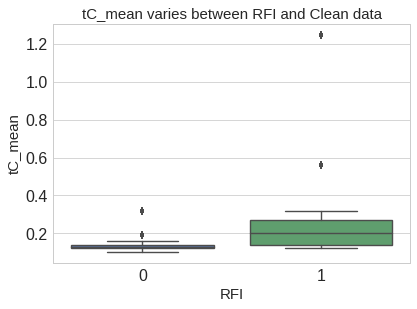

In [19]:
sns.plt.figure()
sns.boxplot(x=X0['rfi'],y=X0[names[1]])
sns.plt.title(str(names[1])+" varies between RFI and Clean data", fontsize=15)
sns.plt.xlabel("RFI",fontsize=15)
sns.plt.ylabel(str(names[1]),fontsize=15)
sns.plt.show()

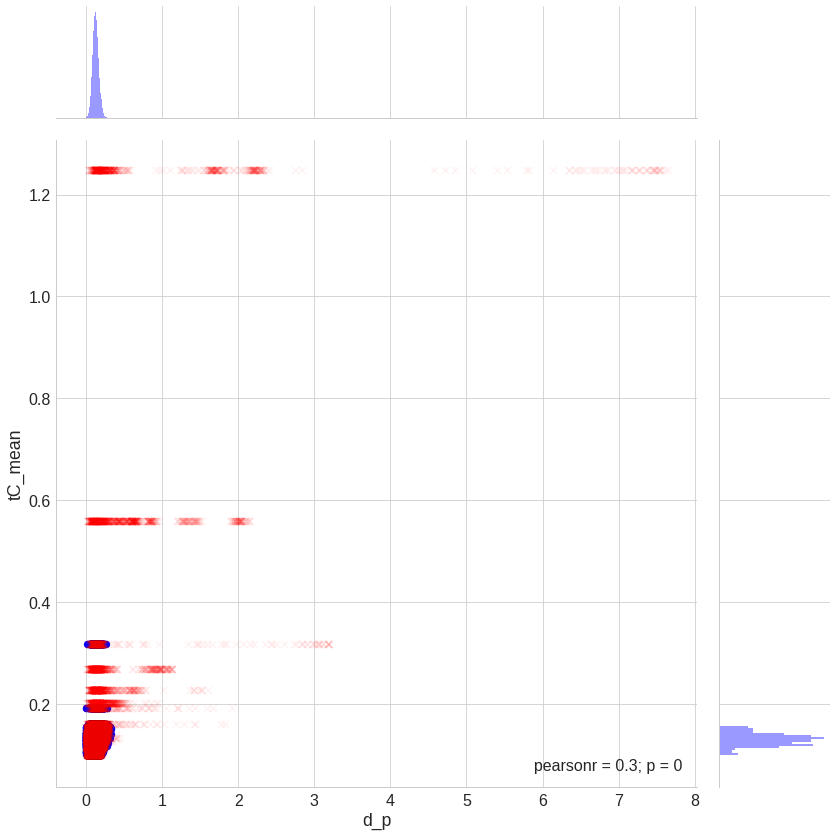

In [20]:
sns.plt.figure()
X1 = X0[X0.rfi==0]
g = sns.jointplot(x=names[0],y=names[1],data=X1, color='blue', size=12,s=50)
X1 = X0[X0.rfi==1]
g.x = X0[names[0]]
g.y = X0[names[1]]
g.plot_joint(sns.plt.scatter, marker='x', c='r', s=50,alpha = 0.05)
#sns.jointplot(x=names[0],y=names[9],data=X1, color='red', size=12)
#sns.plt.xlim(-0.5,1.5)
del X1
sns.plt.show()

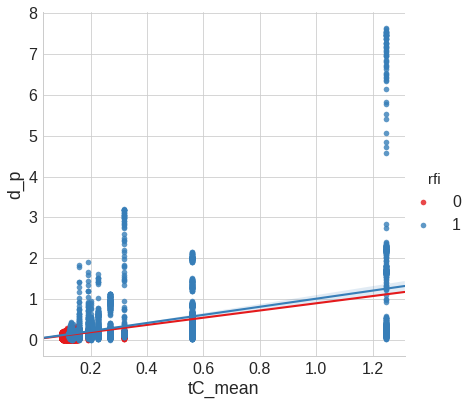

In [21]:
sns.plt.figure(figsize=(14,7))
sns.lmplot(y=names[0],x=names[1],data=X0,hue='rfi',palette='Set1',size=6,)
sns.plt.show()

# Overview of entire feature space

In [22]:
for i in range(10):
    X0= shuffle(X0,random_state=2458)
HH_X0_not = X0[X0["rfi"]==0]
HH_X0_is = X0[X0["rfi"]==1]
X1 = pd.concat([HH_X0_not[:1000],HH_X0_is[:1000]], ignore_index=True)

In [23]:
sns.plt.figure()
sns.set_style("whitegrid")
sns.pairplot(shuffle(X1)[:800], size=3 ,diag_kind="kde",hue="rfi",palette=["b","r"],
             vars=np.unique(list(itertools.combinations(names,2))[:]),markers=["s","^"],
             plot_kws=dict(s=100, edgecolor="k", linewidth=1,alpha=0.8,),
             diag_kws=dict(shade=True))
sns.plt.show()
del X1

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


# Train Test Split

In [24]:
for i in range(10):
    X0= shuffle(X0,random_state=2458)
HH_X0_not = X0[X0["rfi"]==0]
HH_X0_is = X0[X0["rfi"]==1]
X0 = pd.concat([HH_X0_not[:len(HH_X0_is)*4],HH_X0_is[:len(HH_X0_is)]], ignore_index=True)
del HH_X0_not
del HH_X0_is
X0 = shuffle(X0.drop_duplicates())
print len(X0),len(np.unique(X0["d_p"]))

37055 37017


In [25]:
x_train0, x_test0, y_train0, y_test0 = train_test_split(X0[names]
                                        ,X0['rfi'], test_size=0.30
                                        ,random_state=6)

# KNeighborsClassifier

In [26]:
knn = KNeighborsClassifier(n_neighbors=1,n_jobs=-1)
knn.fit(x_train0,y_train0)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=1, p=2,
           weights='uniform')

In [27]:
pred = knn.predict(x_test0)

[[7661 1222]
 [1523  711]]


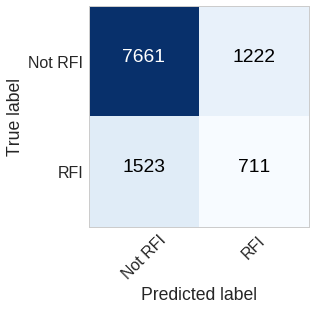

('Misclassification error rate:', 0.247)
('matthews_corrcoef: ', 0.19104719044735596)


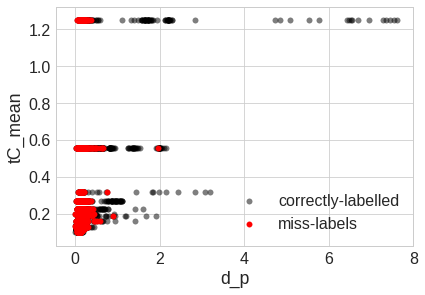

In [28]:
conf_mat=confusion_matrix(y_test0,pred)
print conf_mat
plot_confusion_matrix(conf_mat, classes=target_names,normalize=False)
sns.plt.show()
print("Misclassification error rate:",round(np.mean(pred!=y_test0),3))
print("matthews_corrcoef: ",matthews_corrcoef(y_test0,pred,))
sns.plt.figure()
sns.plt.scatter(x_test0[names[0]],x_test0[names[1]],c='k',alpha=0.5,label='correctly-labelled')
sns.plt.scatter(x_test0[names[0]].values[np.where(y_test0!=pred)[0]],x_test0[names[1]].values[np.where(y_test0!=pred)[0]],c='r',label='miss-labels')
sns.plt.xlabel(names[0])
sns.plt.ylabel(names[1])
sns.plt.legend(loc='best')
sns.plt.show()

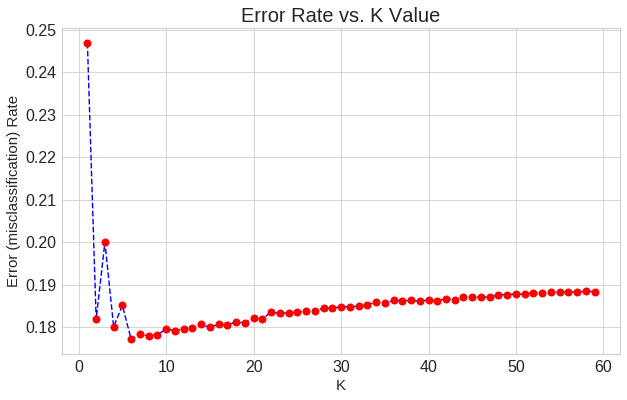

In [29]:
error_rate = []

# Will take some time
for i in range(1,60):
    
    knn = KNeighborsClassifier(n_neighbors=i,n_jobs=-1)
    knn.fit(x_train0,y_train0)
    pred_i = knn.predict(x_test0)
    error_rate.append(np.mean(pred_i != y_test0))

sns.plt.figure(figsize=(10,6))
sns.plt.plot(range(1,60),error_rate,color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=8)
sns.plt.title('Error Rate vs. K Value', fontsize=20)
sns.plt.xlabel('K',fontsize=15)
sns.plt.ylabel('Error (misclassification) Rate',fontsize=15)
sns.plt.show()

# Training a Decision Tree Model

In [30]:
dtree = DecisionTreeClassifier(criterion='gini',max_depth=None)
dtree.fit(x_train0,y_train0)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

### Predictions and Evaluation of Decision Tree
Create predictions from the test set and create a classification report and a confusion matrix.

In [31]:
pred = dtree.predict(x_test0)

[[8789   94]
 [  77 2157]]


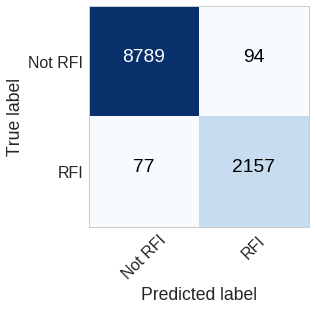

('Misclassification error rate:', 0.015)
('matthews_corrcoef: ', 0.95224947196252419)


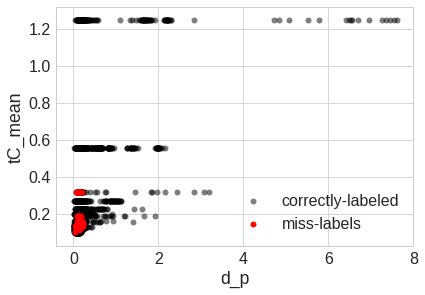

In [32]:
conf_mat=confusion_matrix(y_test0,pred)
print conf_mat
plot_confusion_matrix(conf_mat, classes=target_names,normalize=False)
sns.plt.show()
print("Misclassification error rate:",round(np.mean(pred!=y_test0),3))
print("matthews_corrcoef: ",matthews_corrcoef(y_test0,pred))
sns.plt.figure()
sns.plt.scatter(x_test0[names[0]],x_test0[names[1]],c='k',alpha=0.5,label='correctly-labeled')
sns.plt.scatter(x_test0[names[0]].values[np.where(y_test0!=pred)[0]],x_test0[names[1]].values[np.where(y_test0!=pred)[0]],c='r',label='miss-labels')
sns.plt.xlabel(names[0])
sns.plt.ylabel(names[1])
sns.plt.legend(loc='best')
sns.plt.show()

### Training the Random Forest model
Now its time to train our model!
#### Create an instance of the RandomForestClassifier class and fit it to our training data from the previous step.

In [33]:
rfc = RandomForestClassifier(n_estimators=600, n_jobs=-1)
rfc.fit(x_train0, y_train0)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=600, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [34]:
pred = rfc.predict(x_test0)

[[8845   38]
 [ 219 2015]]


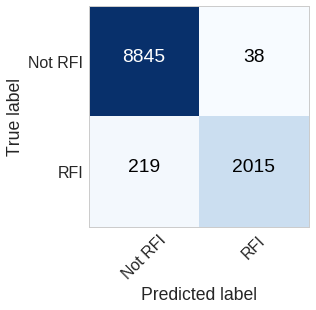

('Misclassification error rate:', 0.023)
('matthews_corrcoef: ', 0.92703091040912455)


In [35]:
conf_mat=confusion_matrix(y_test0,pred)
print conf_mat
plot_confusion_matrix(conf_mat, classes=target_names,normalize=False)
sns.plt.show()
print("Misclassification error rate:",round(np.mean(pred!=y_test0),3))
print("matthews_corrcoef: ",matthews_corrcoef(y_test0,pred))

In [36]:
nsimu = 21
accuracy=[0]*nsimu
ntree = [0]*nsimu
for i in range(1,nsimu):
    rfc = RandomForestClassifier(n_estimators=i*5,min_samples_split=10,max_depth=None,criterion='gini',n_jobs=-1)
    rfc.fit(x_train0, y_train0)
    pred = rfc.predict(x_test0)
    cm = confusion_matrix(y_test0,pred)
    accuracy[i] = (cm[0,0]+cm[1,1])/float(cm.sum())
    ntree[i]=i*5

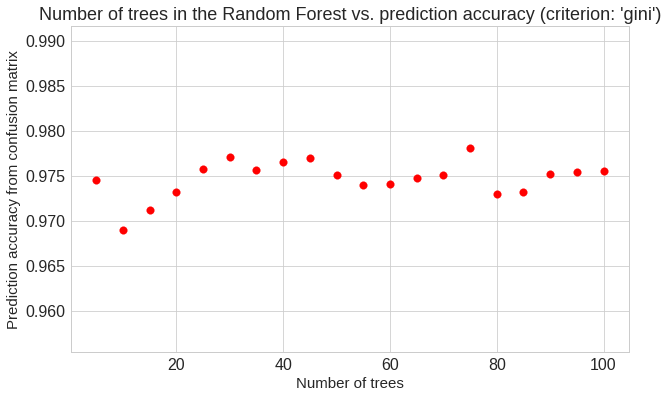

In [37]:
sns.plt.figure(figsize=(10,6))
sns.plt.scatter(x=ntree[1:nsimu],y=accuracy[1:nsimu],s=60,c='red')
sns.plt.title("Number of trees in the Random Forest vs. prediction accuracy (criterion: 'gini')", fontsize=18)
sns.plt.xlabel("Number of trees", fontsize=15)
sns.plt.ylabel("Prediction accuracy from confusion matrix", fontsize=15)
sns.plt.show()

In [38]:
nsimu = 21
accuracy=[0]*nsimu
ntree = [0]*nsimu
for i in range(1,nsimu):
    rfc = RandomForestClassifier(n_estimators=i*5,min_samples_split=10,max_depth=None,criterion='entropy',n_jobs=-1)
    rfc.fit(x_train0, y_train0)
    pred = rfc.predict(x_test0)
    cm = confusion_matrix(y_test0,pred)
    accuracy[i] = (cm[0,0]+cm[1,1])/float(cm.sum())
    ntree[i]=i*5

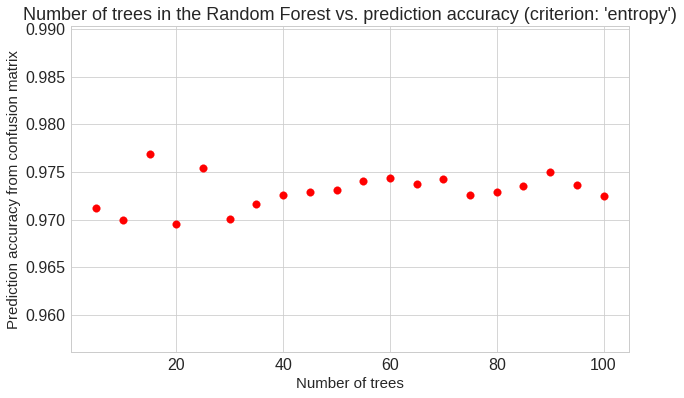

In [39]:
sns.plt.figure(figsize=(10,6))
sns.plt.scatter(x=ntree[1:nsimu],y=accuracy[1:nsimu],s=60,c='red')
sns.plt.title("Number of trees in the Random Forest vs. prediction accuracy (criterion: 'entropy')", fontsize=18)
sns.plt.xlabel("Number of trees", fontsize=15)
sns.plt.ylabel("Prediction accuracy from confusion matrix", fontsize=15)
sns.plt.show()

Fixing max tree depth

In [40]:
nsimu = 21
accuracy=[0]*nsimu
ntree = [0]*nsimu
for i in range(1,nsimu):
    rfc = RandomForestClassifier(n_estimators=i*5,min_samples_split=10,max_depth=None,criterion='gini',n_jobs=-1)
    rfc.fit(x_train0, y_train0)
    pred = rfc.predict(x_test0)
    cm = confusion_matrix(y_test0,pred)
    accuracy[i] = float(cm[0,0]+cm[1,1])/cm.sum()
    ntree[i]=i*5

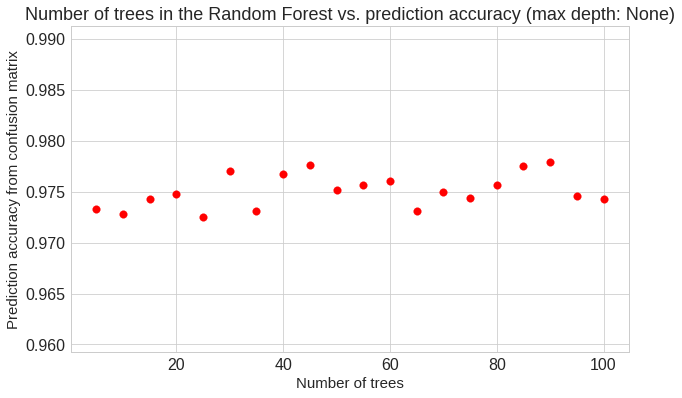

In [41]:
sns.plt.figure(figsize=(10,6))
sns.plt.scatter(x=ntree[1:nsimu],y=accuracy[1:nsimu],s=60,c='red')
sns.plt.title("Number of trees in the Random Forest vs. prediction accuracy (max depth: None)", fontsize=18)
sns.plt.xlabel("Number of trees", fontsize=15)
sns.plt.ylabel("Prediction accuracy from confusion matrix", fontsize=15)
sns.plt.show()

In [42]:
nsimu = 21
accuracy=[0]*nsimu
ntree = [0]*nsimu
for i in range(1,nsimu):
    rfc = RandomForestClassifier(n_estimators=i*5,min_samples_split=10,max_depth=5,criterion='gini',n_jobs=-1)
    rfc.fit(x_train0, y_train0)
    pred = rfc.predict(x_test0)
    cm = confusion_matrix(y_test0,pred)
    accuracy[i] = float(cm[0,0]+cm[1,1])/cm.sum()
    ntree[i]=i*5

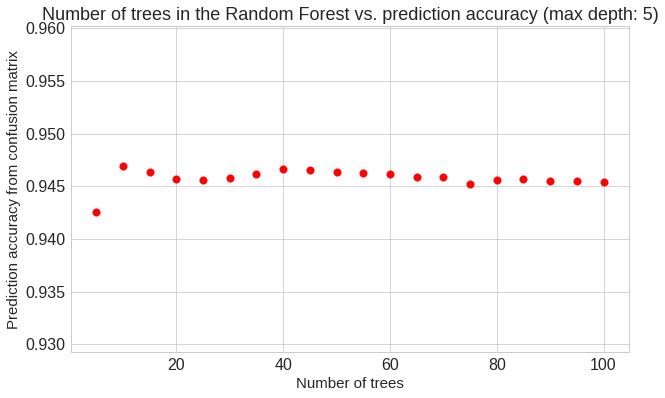

In [43]:
sns.plt.figure(figsize=(10,6))
sns.plt.scatter(x=ntree[1:nsimu],y=accuracy[1:nsimu],s=60,c='red')
sns.plt.title("Number of trees in the Random Forest vs. prediction accuracy (max depth: 5)", fontsize=18)
sns.plt.xlabel("Number of trees", fontsize=15)
sns.plt.ylabel("Prediction accuracy from confusion matrix", fontsize=15)
sns.plt.show()

Minimum sample split criteria

In [44]:
nsimu = 21
accuracy=[0]*nsimu
ntree = [0]*nsimu
for i in range(1,nsimu):
    rfc = RandomForestClassifier(n_estimators=i*5,min_samples_split=2,max_depth=None,criterion='gini',n_jobs=-1)
    rfc.fit(x_train0, y_train0)
    pred = rfc.predict(x_test0)
    cm = confusion_matrix(y_test0,pred)
    accuracy[i] = float(cm[0,0]+cm[1,1])/cm.sum()
    ntree[i]=i*5

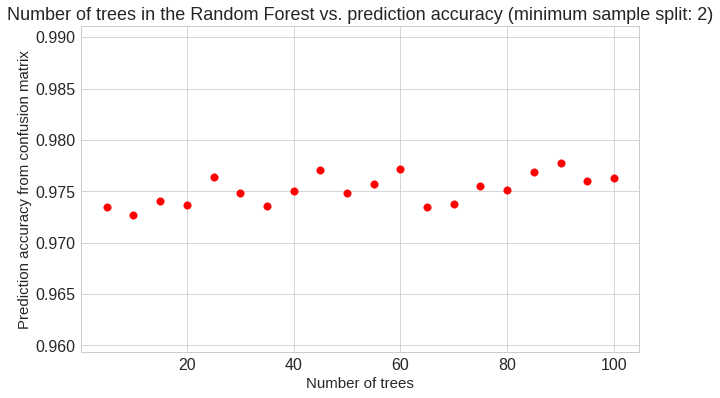

In [45]:
sns.plt.figure(figsize=(10,6))
sns.plt.scatter(x=ntree[1:nsimu],y=accuracy[1:nsimu],s=60,c='red')
sns.plt.title("Number of trees in the Random Forest vs. prediction accuracy (minimum sample split: 2)", fontsize=18)
sns.plt.xlabel("Number of trees", fontsize=15)
sns.plt.ylabel("Prediction accuracy from confusion matrix", fontsize=15)
sns.plt.show()

In [46]:
nsimu = 21
accuracy=[0]*nsimu
ntree = [0]*nsimu
for i in range(1,nsimu):
    rfc = RandomForestClassifier(n_estimators=i*5,min_samples_split=20,max_depth=None,criterion='gini',n_jobs=-1)
    rfc.fit(x_train0, y_train0)
    pred = rfc.predict(x_test0)
    cm = confusion_matrix(y_test0,pred)
    accuracy[i] = float(cm[0,0]+cm[1,1])/cm.sum()
    ntree[i]=i*5

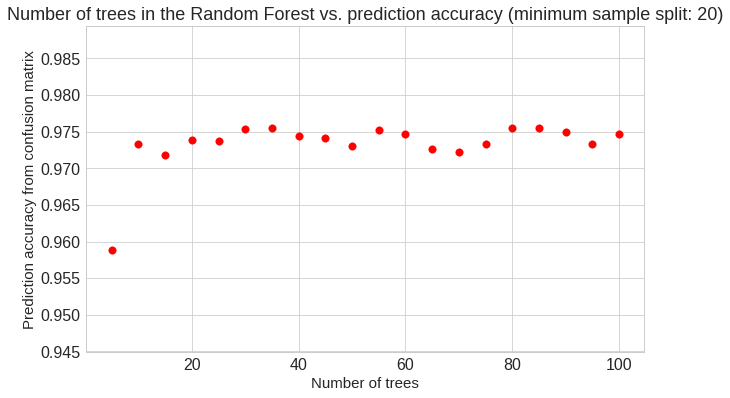

In [47]:
sns.plt.figure(figsize=(10,6))
sns.plt.scatter(x=ntree[1:nsimu],y=accuracy[1:nsimu],s=60,c='red')
sns.plt.title("Number of trees in the Random Forest vs. prediction accuracy (minimum sample split: 20)", fontsize=18)
sns.plt.xlabel("Number of trees", fontsize=15)
sns.plt.ylabel("Prediction accuracy from confusion matrix", fontsize=15)
sns.plt.show()

In [48]:
model_acy_rfc = []
model_acy_gnb = []
model_acy_knn = []
for i in range(100):
    if i % 10 == 0:
        print i,
    X0 = shuffle(X0)
    (training_inputs,
     testing_inputs,
     training_classes,
     testing_classes) = train_test_split(X0[names], X0['rfi'], train_size=0.7)
    
    decision_tree_classifier = RandomForestClassifier(n_jobs=-1,random_state=4)
    decision_tree_classifier.fit(training_inputs, training_classes)
    classifier_accuracy = decision_tree_classifier.score(testing_inputs, testing_classes)
    model_acy_rfc.append(classifier_accuracy)
    
    decision_tree_classifier = GaussianNB()
    decision_tree_classifier.fit(training_inputs, training_classes)
    classifier_accuracy = decision_tree_classifier.score(testing_inputs, testing_classes)
    model_acy_gnb.append(classifier_accuracy)
    
    decision_tree_classifier = KNeighborsClassifier(n_jobs=-1)
    decision_tree_classifier.fit(training_inputs, training_classes)
    classifier_accuracy = decision_tree_classifier.score(testing_inputs, testing_classes)
    model_acy_knn.append(classifier_accuracy)

del training_inputs
del testing_inputs
del training_classes
del testing_classes
del classifier_accuracy
del decision_tree_classifier

0 10 20 30 40 50 60 70 80 90


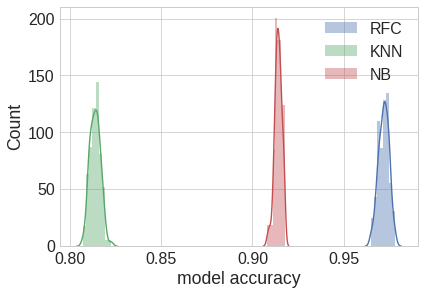

RFC: Mean 0.971915984528 	 std 0.00282141587561
KNN: Mean 0.813886839975 	 std 0.0028673488556
NB:  Mean 0.914136907439 	 std 0.00196872002611


In [49]:
sns.plt.figure()
sns.distplot(model_acy_rfc,label="RFC")
sns.distplot(model_acy_knn,label="KNN")
sns.distplot(model_acy_gnb, label="NB")
sns.plt.ylabel("Count")
sns.plt.xlabel("model accuracy")
sns.plt.legend(loc="best")
sns.plt.grid(True)
sns.plt.show()
print "RFC: Mean {0} \t std {1}".format(np.mean(model_acy_rfc),np.std(model_acy_rfc))
print "KNN: Mean {0} \t std {1}".format(np.mean(model_acy_knn),np.std(model_acy_knn))
print "NB:  Mean {0} \t std {1}".format(np.mean(model_acy_gnb),np.std(model_acy_gnb))

In [50]:
cv = StratifiedKFold(y=y_train0,shuffle=True,n_folds=10,random_state=0)

gnb = GaussianNB()

rfc = RandomForestClassifier(random_state=4)
grid = {'n_estimators': np.arange(1, 50)
        ,'criterion': ['gini', 'entropy']
        ,'max_features':['sqrt','log2']
        ,'max_depth':np.arange(1,50)
        ,'min_samples_split':np.arange(1,50)}
rfc = RandomizedSearchCV(rfc, grid, cv=cv,n_iter=30,random_state=10004,n_jobs=-1)

knn = KNeighborsClassifier()
grid = {"n_neighbors": np.arange(1, 50, 2)
        ,"metric": ["euclidean", "minkowski"]}
knn = RandomizedSearchCV(knn, grid, cv=cv,n_iter=30,random_state=10004,n_jobs=-1)

In [51]:
#cv_scores = cross_val_score(gnb, X0[names],X0['rfi'],cv=15)
#sns.distplot(cv_scores)
#sns.plt.show()

gnb.fit(x_train0,y_train0)

GaussianNB(priors=None)

In [52]:
rfc.fit(x_train0,y_train0)

RandomizedSearchCV(cv=sklearn.cross_validation.StratifiedKFold(labels=[0 0 ..., 0 0], n_folds=10, shuffle=True, random_state=0),
          error_score='raise',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=4, verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=30, n_jobs=-1,
          param_distributions={'n_estimators': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]), 'max_features': ['sqrt', 'log2'], 'min_sampl...27, 28, 29, 30, 31, 32, 33, 34,
       35

In [53]:
knn.fit(x_train0,y_train0)

RandomizedSearchCV(cv=sklearn.cross_validation.StratifiedKFold(labels=[0 0 ..., 0 0], n_folds=10, shuffle=True, random_state=0),
          error_score='raise',
          estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
          fit_params=None, iid=True, n_iter=30, n_jobs=-1,
          param_distributions={'n_neighbors': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33,
       35, 37, 39, 41, 43, 45, 47, 49]), 'metric': ['euclidean', 'minkowski']},
          pre_dispatch='2*n_jobs', random_state=10004, refit=True,
          return_train_score=True, scoring=None, verbose=0)

In [54]:
y_pred_prob_gnb = gnb.predict_proba(x_test0)
y_pred_prob_rfc = rfc.predict_proba(x_test0)
y_pred_prob_knn = knn.predict_proba(x_test0)
y_pred_gnb = gnb.predict(x_test0)
y_pred_rfc = rfc.predict(x_test0)
y_pred_knn = knn.predict(x_test0)

In [55]:
report(rfc.cv_results_,"RFC")

Model with rank: 1
Mean validation score: 0.977 (std: 0.003)
Parameters: {'n_estimators': 23, 'min_samples_split': 17, 'criterion': 'gini', 'max_depth': 43, 'max_features': 'log2'}

Model with rank: 2
Mean validation score: 0.977 (std: 0.003)
Parameters: {'n_estimators': 39, 'min_samples_split': 15, 'criterion': 'gini', 'max_depth': 46, 'max_features': 'sqrt'}

Model with rank: 3
Mean validation score: 0.976 (std: 0.002)
Parameters: {'n_estimators': 48, 'min_samples_split': 21, 'criterion': 'gini', 'max_depth': 39, 'max_features': 'log2'}



In [56]:
report(knn.cv_results_,"KNN")

Model with rank: 1
Mean validation score: 0.821 (std: 0.004)
Parameters: {'n_neighbors': 13, 'metric': 'minkowski'}

Model with rank: 1
Mean validation score: 0.821 (std: 0.004)
Parameters: {'n_neighbors': 13, 'metric': 'euclidean'}

Model with rank: 3
Mean validation score: 0.820 (std: 0.004)
Parameters: {'n_neighbors': 11, 'metric': 'minkowski'}



In [57]:
rfc=rfc.best_estimator_
knn=knn.best_estimator_

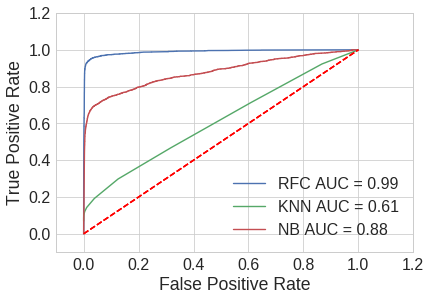

In [58]:
model_names =['RFC','KNN','NB']
roc_plot([y_pred_prob_rfc,y_pred_prob_knn,y_pred_prob_gnb],False,model_names)
sns.plt.grid(True)
sns.plt.show()

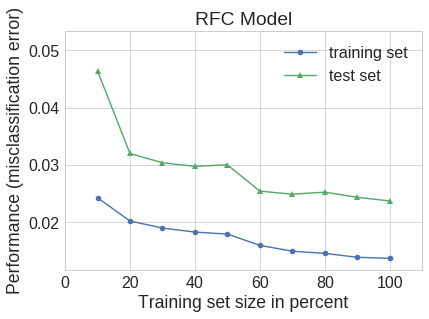

In [59]:
sns.plt.figure()
plot_learning_curves(x_train0.values, y_train0.values, x_test0.values, y_test0.values, rfc
                     ,print_model=False,style="seaborn-whitegrid")
sns.plt.title('RFC Model')
sns.plt.show()

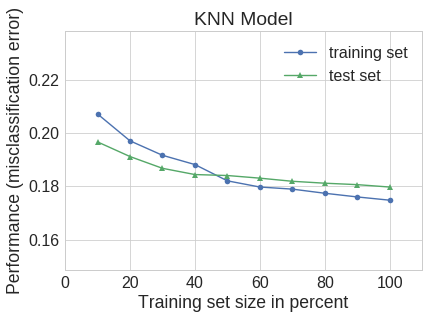

In [60]:
sns.plt.figure()
plot_learning_curves(x_train0.values, y_train0.values, x_test0.values, y_test0.values, knn
                     ,print_model=False,style="seaborn-whitegrid")
sns.plt.title('KNN Model')
sns.plt.show()

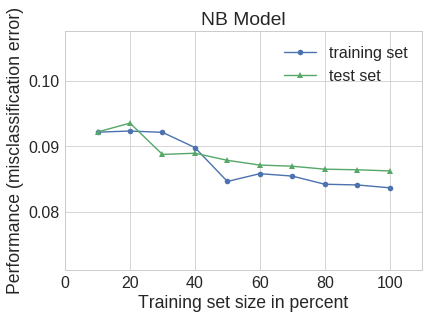

In [61]:
sns.plt.figure()
plot_learning_curves(x_train0.values, y_train0.values, x_test0.values, y_test0.values, gnb
                     ,print_model=False,style="seaborn-whitegrid")
sns.plt.title('NB Model')

sns.plt.show()

Classification Report for RFC
             precision    recall  f1-score   support

    Not RFI       0.98      0.99      0.99      8883
        RFI       0.98      0.90      0.94      2234

avg / total       0.98      0.98      0.98     11117


 The model is 97.625259 accurate


[[8836   47]
 [ 217 2017]]


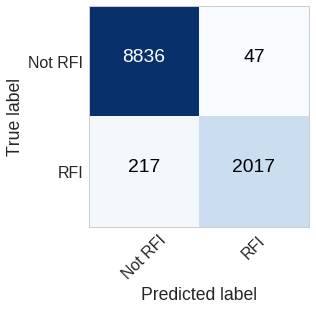

('Misclassification error rate:', 0.024)
('matthews_corrcoef: ', 0.92499733461666711)


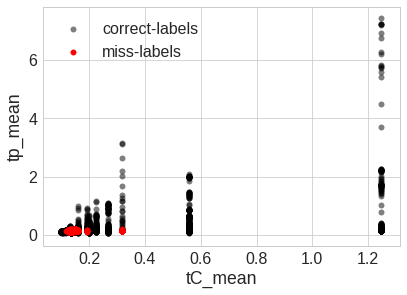

In [62]:
evaluate(y_pred_rfc,'RFC')
conf_mat=confusion_matrix(y_test0,y_pred_rfc)
print conf_mat
plot_confusion_matrix(conf_mat, classes=target_names,normalize=False)
sns.plt.show()
print("Misclassification error rate:",round(np.mean(y_pred_rfc!=y_test0),3))
print("matthews_corrcoef: ",matthews_corrcoef(y_test0,y_pred_rfc))
sns.plt.figure()
sns.plt.scatter(x_test0[names[1]],x_test0[names[2]],c='k',alpha=0.5,label='correct-labels')
sns.plt.scatter(x_test0[names[1]].values[np.where(y_test0!=y_pred_rfc)[0]],x_test0[names[2]].values[np.where(y_test0!=y_pred_rfc)[0]],c='r',label='miss-labels')
sns.plt.xlabel(names[1])
sns.plt.ylabel(names[2])
sns.plt.legend(loc='best')
sns.plt.show()

Classification Report for KNN
             precision    recall  f1-score   support

    Not RFI       0.82      1.00      0.90      8883
        RFI       0.88      0.12      0.21      2234

avg / total       0.83      0.82      0.76     11117


 The model is 82.027525 accurate


[[8847   36]
 [1962  272]]


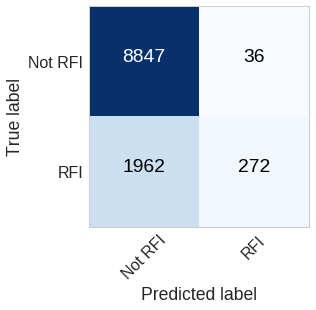

('Misclassification error rate:', 0.18)
('matthews_corrcoef: ', 0.28736720058032283)


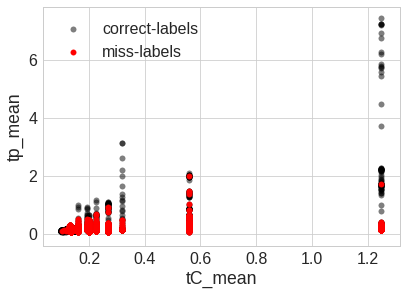

In [63]:
evaluate(y_pred_knn,'KNN')
conf_mat=confusion_matrix(y_test0,y_pred_knn)
print conf_mat
plot_confusion_matrix(conf_mat, classes=target_names,normalize=False)
sns.plt.show()
print("Misclassification error rate:",round(np.mean(y_pred_knn!=y_test0),3))
print("matthews_corrcoef: ",matthews_corrcoef(y_test0,y_pred_knn))
sns.plt.figure()
sns.plt.scatter(x_test0[names[1]],x_test0[names[2]],c='k',alpha=0.5,label='correct-labels')
sns.plt.scatter(x_test0[names[1]].values[np.where(y_test0!=y_pred_knn)[0]],x_test0[names[2]].values[np.where(y_test0!=y_pred_knn)[0]],c='r',label='miss-labels')
sns.plt.xlabel(names[1])
sns.plt.ylabel(names[2])
sns.plt.legend(loc='best')
sns.plt.show()

Classification Report for NB
             precision    recall  f1-score   support

    Not RFI       0.92      0.97      0.95      8883
        RFI       0.87      0.68      0.76      2234

avg / total       0.91      0.91      0.91     11117


 The model is 91.373572 accurate


[[8650  233]
 [ 726 1508]]


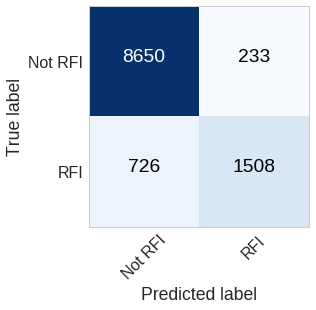

('Misclassification error rate:', 0.086)
('matthews_corrcoef: ', 0.71535077846042794)


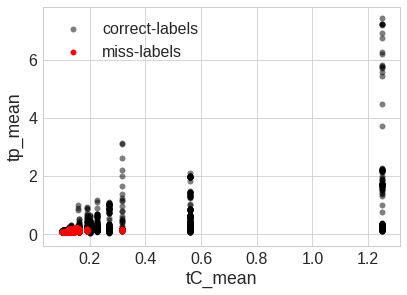

In [64]:
evaluate(y_pred_gnb,'NB')
conf_mat=confusion_matrix(y_test0,y_pred_gnb)
print conf_mat
plot_confusion_matrix(conf_mat, classes=target_names,normalize=False)
sns.plt.show()
print("Misclassification error rate:",round(np.mean(y_pred_gnb!=y_test0),3))
print("matthews_corrcoef: ",matthews_corrcoef(y_test0,y_pred_gnb))
sns.plt.figure()
sns.plt.scatter(x_test0[names[1]],x_test0[names[2]],c='k',alpha=0.5,label='correct-labels')
sns.plt.scatter(x_test0[names[1]].values[np.where(y_test0!=y_pred_gnb)[0]],x_test0[names[2]].values[np.where(y_test0!=y_pred_gnb)[0]],c='r',label='miss-labels')
sns.plt.xlabel(names[1])
sns.plt.ylabel(names[2])
sns.plt.legend(loc='best')
sns.plt.show()

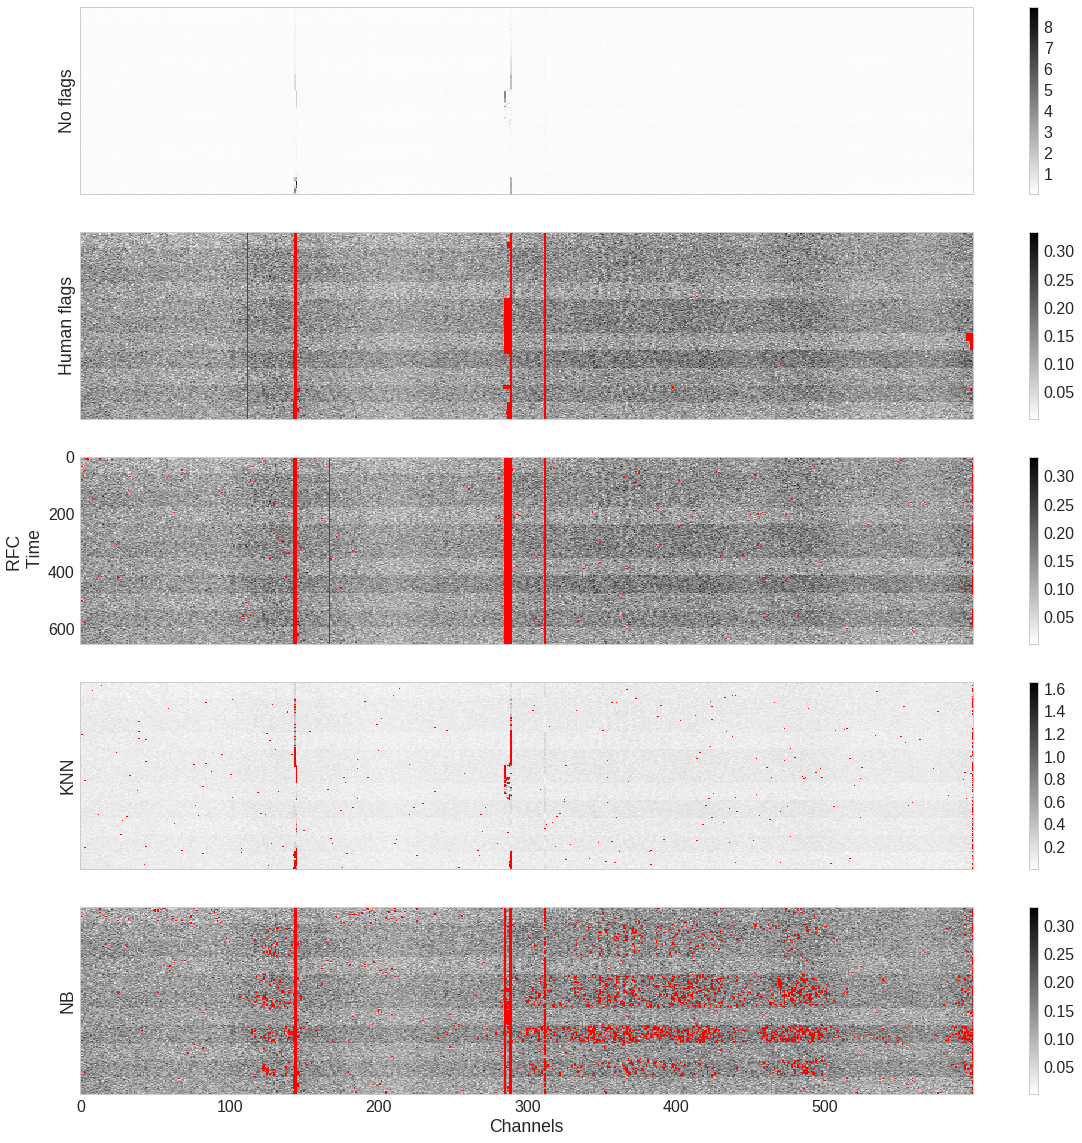

In [65]:
testVV = pd.DataFrame.from_csv('HH1333134985_pks1613-586.1822.ms_all_data_baseline0and1.csv')
#testVV = testVV.replace(to_replace=np.nan,value=0.0)
rfi_rfc =rfc.predict(testVV[names])
rfi_knn = knn.predict(testVV[names])
rfi_gnb = gnb.predict(testVV[names])

image = np.reshape(testVV['d_p'],(len(testVV)/len(np.unique(testVV['frequency'])),len(np.unique(testVV['frequency']))), order='F' )
org_flags = np.reshape(testVV['rfi'],(len(testVV)/len(np.unique(testVV['frequency'])),len(np.unique(testVV['frequency']))), order='F')
rfc_flags = np.reshape(rfi_rfc,(len(testVV)/len(np.unique(testVV['frequency'])),len(np.unique(testVV['frequency']))), order='F')
knn_flags = np.reshape(rfi_knn,(len(testVV)/len(np.unique(testVV['frequency'])),len(np.unique(testVV['frequency']))), order='F')
gnb_flags = np.reshape(rfi_gnb,(len(testVV)/len(np.unique(testVV['frequency'])),len(np.unique(testVV['frequency']))), order='F')


sns.plt.figure(figsize=(20,20))
sns.plt.subplot(5,1,1)
sns.plt.imshow(image,cmap=palette,aspect ='auto')
sns.plt.grid(False)
sns.plt.colorbar()
#sns.plt.xlabel("Channels")
sns.plt.ylabel("No flags")
sns.plt.xticks([])
sns.plt.yticks([])

sns.plt.subplot(5,1,2)
sns.plt.imshow(np.ma.array(image,mask=org_flags),cmap=palette,aspect ='auto')
sns.plt.grid(False)
sns.plt.colorbar()
#sns.plt.xlabel("Channels")
sns.plt.ylabel("Human flags")
sns.plt.xticks([])
sns.plt.yticks([])


sns.plt.subplot(5,1,3)
sns.plt.imshow(np.ma.array(image,mask=rfc_flags),cmap=palette,aspect ='auto')
sns.plt.grid(False)
sns.plt.colorbar()
#sns.plt.xlabel("Channels")
sns.plt.ylabel("Time")
#sns.plt.xlabel("Channels")
sns.plt.ylabel("RFC \n Time")
sns.plt.xticks([])


sns.plt.subplot(5,1,4)
sns.plt.imshow(np.ma.array(image,mask=knn_flags),cmap=palette,aspect ='auto')
sns.plt.grid(False)
sns.plt.colorbar()
#sns.plt.xlabel("Channels")
sns.plt.ylabel("KNN")
sns.plt.xticks([])
sns.plt.yticks([])

sns.plt.subplot(5,1,5)
sns.plt.imshow(np.ma.array(image,mask=gnb_flags),cmap=palette,aspect ='auto')
sns.plt.grid(False)
sns.plt.colorbar()
sns.plt.xlabel("Channels")
sns.plt.ylabel("NB")
sns.plt.yticks([])
#sns.plt.savefig("Results/HH/seen_HH-model_flags2.png",dpi=600)
sns.plt.show()

$$MCC = \frac{\text{TP * TN - FP * FN} }{\sqrt{\text{(TP + FP) * (TP + FN) * (TN + FP) * (TN + FN)}}}$$

In [66]:
def mcc(org_ao):
    tn, fp, fn, tp = org_ao.ravel()
    up = np.float64( (tp*tn) - (fp*fn)  )
    bottom = np.sqrt(np.float64( np.float64(tp+fp) * np.float64(tp+fn) * np.float64(tn+fp) * np.float64(tn+fn) ))
    return up/bottom

In [67]:
filenames = []
rfc_var = []
data_var = []
ao_var = []
human_var = []
ao_mis_var = []
rfc_mis_var = []

rfc_mean = []
data_mean = []
ao_mean = []
human_mean = []
ao_mis_mean = []
rfc_mis_mean = []

rfc_medi = []
data_medi = []
ao_medi = []
human_medi = []
ao_mis_medi = []
rfc_mis_medi = []


rfc_max = []
data_max = []
human_max = []
ao_max = []
ao_mis_max = []
rfc_mis_max = []

ao_mcc = []
rfc_mcc = []
org_mcc = []

ao_per = []
rfc_per = []
human_per = []
for i in glob.glob("**/*pks1613*.ms")[:]:
    if 'precal' in i:
        pass
    else:
        MSfile = i
        t = table(MSfile)
        A1 = t.getcol("ANTENNA1")
        A2 = t.getcol("ANTENNA2")
        ant_list = list(set(np.append(A1,A2)))
        nants = len(ant_list)
        flags = t.getcol("FLAG")
        for b in glob.glob("HH"+i.replace("/","_")+"*.csv")[:]:
            filenames.append(b)
            testVV = pd.DataFrame.from_csv(b)
            ants = b.split("baseline")[1].split('.')[0].split("and")
            ant1 = int(ants[0])
            ant2 = int(ants[1])
            poln = 0
            if np.shape(flags)[1]>800:
                flag_mask = np.array(flags[(A1==ant1) & (A2==ant2)][:,200:800,poln])
            else:
                flag_mask = np.array(flags[(A1==ant1) & (A2==ant2)][:,:,poln])
            
            rfi_rfc =rfc.predict(testVV[names])
            
            image = np.reshape(testVV['d_p'],(len(testVV)/len(np.unique(testVV['frequency'])),len(np.unique(testVV['frequency']))), order='F' )
            org_flags = np.reshape(testVV['rfi'],(len(testVV)/len(np.unique(testVV['frequency'])),len(np.unique(testVV['frequency']))), order='F')
            rfc_flags = np.reshape(rfi_rfc,(len(testVV)/len(np.unique(testVV['frequency'])),len(np.unique(testVV['frequency']))), order='F')
            
            org_flags = org_flags.flatten()
            rfc_flags = rfc_flags.flatten()
            flag_mask = flag_mask.flatten()
            image = image.flatten()
            
            org_rfc = mcc(confusion_matrix(org_flags,rfc_flags))
            org_ao = mcc(confusion_matrix(org_flags,flag_mask))
            org_org = mcc(confusion_matrix(org_flags,org_flags))
            
            ao_mcc.append(org_ao)
            rfc_mcc.append(org_rfc)
            org_mcc.append(org_org)
            
            ao_per.append(np.sum(flag_mask)/float(len(flag_mask)))
            rfc_per.append(np.sum(rfc_flags)/float(len(rfc_flags)))
            human_per.append(np.sum(org_flags)/float(len(org_flags)))

            
            ################ varience ##################################
            rfc_var.append(np.ma.array(image,mask=rfc_flags).var())
            data_var.append(image.var())
            human_var.append(np.ma.array(image,mask=org_flags).var())
            ao_var.append(np.ma.array(image,mask=flag_mask).var())
            
            ao_mis_var.append(np.ma.array(image,mask=(org_flags!=flag_mask)).var())
            rfc_mis_var.append(np.ma.array(image,mask=(org_flags!=rfc_flags)).var())
            
            ################ mean ##################################
            rfc_mean.append(np.ma.array(image,mask=rfc_flags).mean())
            data_mean.append(image.mean())
            human_mean.append(np.ma.array(image,mask=org_flags).mean())
            ao_mean.append(np.ma.array(image,mask=flag_mask).mean())
            
            ao_mis_mean.append(np.ma.array(image,mask=(org_flags!=flag_mask)).mean())
            rfc_mis_mean.append(np.ma.array(image,mask=(org_flags!=rfc_flags)).mean())
            
            ################# median ################################
            rfc_medi.append(np.ma.median(np.ma.array(image,mask=rfc_flags)))
            data_medi.append(np.ma.median(image))
            human_medi.append(np.ma.median(np.ma.array(image,mask=org_flags)))
            ao_medi.append(np.ma.median(np.ma.array(image,mask=flag_mask)))
            
            ao_mis_medi.append(np.ma.median(np.ma.array(image,mask=(org_flags!=flag_mask))))
            rfc_mis_medi.append(np.ma.median(np.ma.array(image,mask=(org_flags!=rfc_flags))))

            ################### max ###################
            rfc_max.append(np.ma.array(image,mask=rfc_flags).max())
            data_max.append(image.max())
            human_max.append(np.ma.array(image,mask=org_flags).max())
            ao_max.append(np.ma.array(image,mask=flag_mask).max())
            
            ao_mis_max.append(np.ma.array(image,mask=(org_flags!=flag_mask)).max())
            rfc_mis_max.append(np.ma.array(image,mask=(org_flags!=rfc_flags)).max())

Successful readonly open of default-locked table 1324619115/pks1613-586.1826.ms: 23 columns, 82200 rows
Successful readonly open of default-locked table 1333134985/pks1613-586.1822.ms: 23 columns, 18340 rows
Successful readonly open of default-locked table 1333305511/pks1613-586.1822.ms: 23 columns, 21728 rows


In [68]:
A_data = {"ao_per":ao_per,'ao_mcc':ao_mcc,'ao_mis_max':ao_mis_max,'ao_max':ao_max
          ,'ao_mis_medi':ao_mis_medi,'ao_medi':ao_medi,'ao_mis_mean':ao_mis_mean
          ,'ao_mean':ao_mean,'ao_mis_var':ao_mis_var,'ao_var':ao_var
          ,"rfc_per":rfc_per,'rfc_mcc':rfc_mcc,'rfc_mis_max':rfc_mis_max,'rfc_max':rfc_max
          ,'rfc_mis_medi':rfc_mis_medi,'rfc_medi':rfc_medi,'rfc_mis_mean':rfc_mis_mean
          ,'rfc_mean':rfc_mean,'rfc_mis_var':rfc_mis_var,'rfc_var':rfc_var
          ,'data_max':data_max
          ,'data_medi':data_medi
          ,'data_mean':data_mean,'data_var':data_var
          ,"human_per":human_per,'human_mcc':org_mcc,'human_max':human_max
          ,'human_medi':human_medi
          ,'human_mean':human_mean,'human_var':human_var,"file":filenames}
A_data = pd.DataFrame.from_dict(A_data)
A_data.head()

ao_max    ao_mcc   ao_mean   ao_medi  ao_mis_max  ao_mis_mean  \
0  0.320376  0.004738  0.117698  0.116861    0.503411     0.117757   
1  0.328198  0.008371  0.130441  0.129689    0.330566     0.130479   
2  0.357033  0.010499  0.118471  0.117777    0.357033     0.118489   
3  0.337167  0.007952  0.119360  0.118408    0.424558     0.119405   
4  0.337697  0.003538  0.134461  0.133945    0.547675     0.134517   

   ao_mis_medi  ao_mis_var    ao_per    ao_var    ...      rfc_max   rfc_mcc  \
0     0.116906    0.001499  0.168075  0.001493    ...     0.510610  0.000905   
1     0.129729    0.001523  0.064521  0.001523    ...     0.380940 -0.001816   
2     0.117796    0.001417  0.019512  0.001417    ...     0.540088 -0.001566   
3     0.118440    0.001427  0.143643  0.001423    ...     1.578154 -0.003561   
4     0.133997    0.001589  0.099461  0.001586    ...     0.566480 -0.005040   

   rfc_mean  rfc_medi rfc_mis_max  rfc_mis_mean  rfc_mis_medi  rfc_mis_var  \
0  0.119165  0.117945    0.510610      0.119211      0.117979     0.001639   
1  0.130723  0.129906    0.380940      0.130754      0.129940     0.001567   
2  0.118304  0.117679    0.540088      0.118323      0.117698     0.001413   
3  0.120161  0.118941    1.578154      0.120194      0.118966     0.001558   
4  0.135253  0.134567    0.566480      0.135306      0.134615     0.001636   

    rfc_per   rfc_var  
0  0.067644  0.001635  
1  0.024258  0.001568  
2  0.010949  0.001412  
3  0.054128  0.001555  
4  0.056749  0.001634  

[5 rows x 31 columns]

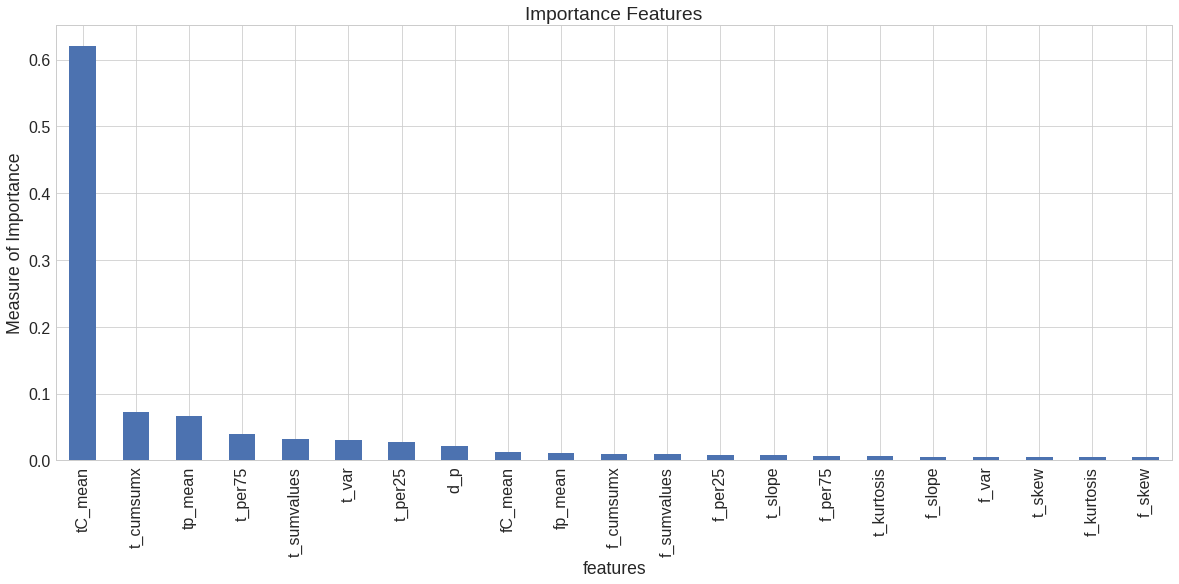

/data/olorato/mywork/lib/python2.7/site-packages/ipykernel_launcher.py:22: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


In [69]:
importances = rfc.feature_importances_
std = np.std([tree.feature_importances_ for tree in rfc.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

feature_space= []
# Print the feature ranking
impdf = []
for f in range(x_train0.shape[1]):
    feature_space.append(names[indices[f]])
    impdf.append({'features': names[indices[f]], 'importance': importances[indices[f]]})

impdf = pd.DataFrame(impdf)
impdf = impdf.sort_values(by='importance', ascending=False).reset_index(drop=True)
impdf['importance'] /= impdf['importance'].sum()
impdf.index = impdf['features']
sns.plt.figure()
impdf.plot(kind='bar', title='Importance Features', figsize=(20, 8),legend=False,fontsize=16.0)
sns.plt.ylabel("Measure of Importance")
sns.plt.grid(True)
sns.plt.show()
impdf = impdf.sort('importance')

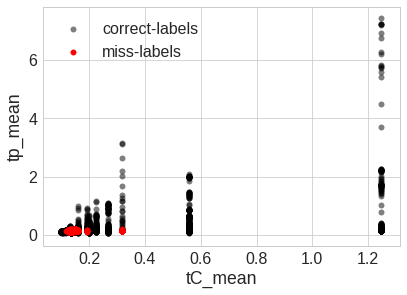

In [70]:
sns.plt.figure()
sns.plt.scatter(x_test0[names[1]],x_test0[names[2]],c='k',alpha=0.5,label='correct-labels')
sns.plt.scatter(x_test0[names[1]].values[np.where(y_test0!=y_pred_rfc)[0]],x_test0[names[2]].values[np.where(y_test0!=y_pred_rfc)[0]],c='r',label='miss-labels')
sns.plt.xlabel(names[1])
sns.plt.ylabel(names[2])
sns.plt.legend(loc='best')
sns.plt.show()

In [71]:
impdf[-6:]['features'].values

array(['t_var', 't_sumvalues', 't_per75', 'tp_mean', 't_cumsumx', 'tC_mean'], dtype=object)

In [72]:
model_acy_rfc = []
model_acy_gnb = []
model_acy_knn = []
for i in range(100):
    if i % 10 == 0:
        print i,
    X0 = shuffle(X0)
    (training_inputs,
     testing_inputs,
     training_classes,
     testing_classes) = train_test_split(X0[impdf[-6:]['features'].values], X0['rfi'], train_size=0.7)
    
    decision_tree_classifier = RandomForestClassifier(n_jobs=-1,random_state=4)
    decision_tree_classifier.fit(training_inputs, training_classes)
    classifier_accuracy = decision_tree_classifier.score(testing_inputs, testing_classes)
    model_acy_rfc.append(classifier_accuracy)
    
    decision_tree_classifier = GaussianNB()
    decision_tree_classifier.fit(training_inputs, training_classes)
    classifier_accuracy = decision_tree_classifier.score(testing_inputs, testing_classes)
    model_acy_gnb.append(classifier_accuracy)
    
    decision_tree_classifier = KNeighborsClassifier(n_jobs=-1)
    decision_tree_classifier.fit(training_inputs, training_classes)
    classifier_accuracy = decision_tree_classifier.score(testing_inputs, testing_classes)
    model_acy_knn.append(classifier_accuracy)

del training_inputs
del testing_inputs
del training_classes
del testing_classes
del classifier_accuracy
del decision_tree_classifier

0 10 20 30 40 50 60 70 80 90


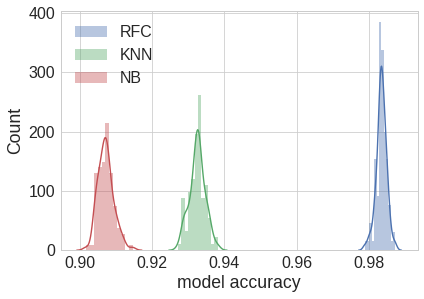

RFC: Mean 0.983488351174 	 std 0.00141498867595
KNN: Mean 0.932573536026 	 std 0.00214638311766
NB:  Mean 0.907218674103 	 std 0.00215237607368


In [73]:
sns.distplot(model_acy_rfc,label="RFC")
sns.distplot(model_acy_knn,label="KNN")
sns.distplot(model_acy_gnb, label="NB")
sns.plt.ylabel("Count")
sns.plt.xlabel("model accuracy")
sns.plt.legend(loc="best")
sns.plt.grid(True)
sns.plt.show()
print "RFC: Mean {0} \t std {1}".format(np.mean(model_acy_rfc),np.std(model_acy_rfc))
print "KNN: Mean {0} \t std {1}".format(np.mean(model_acy_knn),np.std(model_acy_knn))
print "NB:  Mean {0} \t std {1}".format(np.mean(model_acy_gnb),np.std(model_acy_gnb))

In [74]:
impdf[-3:]['features'].values

array(['tp_mean', 't_cumsumx', 'tC_mean'], dtype=object)

In [75]:
model_acy_rfc = []
model_acy_gnb = []
model_acy_knn = []
for i in range(100):
    if i % 10 == 0:
        print i,
    X0 = shuffle(X0)
    (training_inputs,
     testing_inputs,
     training_classes,
     testing_classes) = train_test_split(X0[impdf[-3:]['features'].values], X0['rfi'], train_size=0.7)
    
    decision_tree_classifier = RandomForestClassifier(n_jobs=-1,random_state=4)
    decision_tree_classifier.fit(training_inputs, training_classes)
    classifier_accuracy = decision_tree_classifier.score(testing_inputs, testing_classes)
    model_acy_rfc.append(classifier_accuracy)
    
    decision_tree_classifier = GaussianNB()
    decision_tree_classifier.fit(training_inputs, training_classes)
    classifier_accuracy = decision_tree_classifier.score(testing_inputs, testing_classes)
    model_acy_gnb.append(classifier_accuracy)
    
    decision_tree_classifier = KNeighborsClassifier(n_jobs=-1)
    decision_tree_classifier.fit(training_inputs, training_classes)
    classifier_accuracy = decision_tree_classifier.score(testing_inputs, testing_classes)
    model_acy_knn.append(classifier_accuracy)

del training_inputs
del testing_inputs
del training_classes
del testing_classes
del classifier_accuracy
del decision_tree_classifier

0 10 20 30 40 50 60 70 80 90


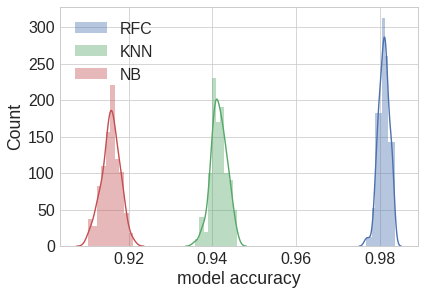

RFC: Mean 0.980940901322 	 std 0.00132100004778
KNN: Mean 0.941564270936 	 std 0.00189480062696
NB:  Mean 0.915682288387 	 std 0.00217225162373


In [76]:
sns.distplot(model_acy_rfc,label="RFC")
sns.distplot(model_acy_knn,label="KNN")
sns.distplot(model_acy_gnb, label="NB")
sns.plt.ylabel("Count")
sns.plt.xlabel("model accuracy")
sns.plt.legend(loc="best")
sns.plt.grid(True)
sns.plt.show()
print "RFC: Mean {0} \t std {1}".format(np.mean(model_acy_rfc),np.std(model_acy_rfc))
print "KNN: Mean {0} \t std {1}".format(np.mean(model_acy_knn),np.std(model_acy_knn))
print "NB:  Mean {0} \t std {1}".format(np.mean(model_acy_gnb),np.std(model_acy_gnb))

# feature Selection

In [77]:
score = fisher_score.fisher_score(x_train0, y_train0)

In [78]:
idx = fisher_score.feature_ranking(score)
print idx
print x_train0[idx[:5]].keys()
print impdf[-5:]['features'].values

[ 1  9  6  2  5  0  8 11 19 18 10 20 12 15 16 13 14  4  3 17  7]
Index([u'tC_mean', u't_per75', u't_sumvalues', u'tp_mean', u't_cumsumx'], dtype='object')
['t_sumvalues' 't_per75' 'tp_mean' 't_cumsumx' 'tC_mean']


In [79]:
model_acy_rfc = []
model_acy_gnb = []
model_acy_knn = []
for i in range(100):
    if i % 10 == 0:
        print i,
    X0 = shuffle(X0)
    (training_inputs,
     testing_inputs,
     training_classes,
     testing_classes) = train_test_split(X0[idx[:5]], X0['rfi'], train_size=0.7)
    
    decision_tree_classifier = RandomForestClassifier(n_jobs=-1,random_state=4)
    decision_tree_classifier.fit(training_inputs, training_classes)
    classifier_accuracy = decision_tree_classifier.score(testing_inputs, testing_classes)
    model_acy_rfc.append(classifier_accuracy)
    
    decision_tree_classifier = GaussianNB()
    decision_tree_classifier.fit(training_inputs, training_classes)
    classifier_accuracy = decision_tree_classifier.score(testing_inputs, testing_classes)
    model_acy_gnb.append(classifier_accuracy)
    
    decision_tree_classifier = KNeighborsClassifier(n_jobs=-1)
    decision_tree_classifier.fit(training_inputs, training_classes)
    classifier_accuracy = decision_tree_classifier.score(testing_inputs, testing_classes)
    model_acy_knn.append(classifier_accuracy)

del training_inputs
del testing_inputs
del training_classes
del testing_classes
del classifier_accuracy
del decision_tree_classifier

0 10 20 30 40 50 60 70 80 90


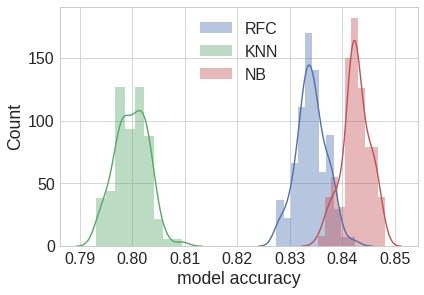

RFC: Mean 0.834112620311 	 std 0.00283902007898
KNN: Mean 0.799903751012 	 std 0.00313396934914
NB:  Mean 0.842542052712 	 std 0.00264038560581


In [80]:
sns.distplot(model_acy_rfc,label="RFC")
sns.distplot(model_acy_knn,label="KNN")
sns.distplot(model_acy_gnb, label="NB")
sns.plt.ylabel("Count")
sns.plt.xlabel("model accuracy")
sns.plt.legend(loc="best")
sns.plt.grid(True)
sns.plt.show()
print "RFC: Mean {0} \t std {1}".format(np.mean(model_acy_rfc),np.std(model_acy_rfc))
print "KNN: Mean {0} \t std {1}".format(np.mean(model_acy_knn),np.std(model_acy_knn))
print "NB:  Mean {0} \t std {1}".format(np.mean(model_acy_gnb),np.std(model_acy_gnb))

In [81]:
score = reliefF.reliefF(x_train0.values, y_train0.values)

In [82]:
idx = reliefF.feature_ranking(score)
print idx
print x_train0[idx[:5]].keys()
print impdf[-6:]['features'].values

[20 16 15 17  7  5  6 14 13  1 12  4  3  9  2  0  8 19 18 10 11]
Index([u'f_var', u'f_sumvalues', u'f_cumsumx', u'f_slope', u't_slope'], dtype='object')
['t_var' 't_sumvalues' 't_per75' 'tp_mean' 't_cumsumx' 'tC_mean']


In [83]:
model_acy_rfc = []
model_acy_gnb = []
model_acy_knn = []
for i in range(100):
    if i % 10 == 0:
        print i,
    X0 = shuffle(X0)
    (training_inputs,
     testing_inputs,
     training_classes,
     testing_classes) = train_test_split(X0[idx[:5]], X0['rfi'], train_size=0.7)
    
    decision_tree_classifier = RandomForestClassifier(n_jobs=-1,random_state=4)
    decision_tree_classifier.fit(training_inputs, training_classes)
    classifier_accuracy = decision_tree_classifier.score(testing_inputs, testing_classes)
    model_acy_rfc.append(classifier_accuracy)
    
    decision_tree_classifier = GaussianNB()
    decision_tree_classifier.fit(training_inputs, training_classes)
    classifier_accuracy = decision_tree_classifier.score(testing_inputs, testing_classes)
    model_acy_gnb.append(classifier_accuracy)
    
    decision_tree_classifier = KNeighborsClassifier(n_jobs=-1)
    decision_tree_classifier.fit(training_inputs, training_classes)
    classifier_accuracy = decision_tree_classifier.score(testing_inputs, testing_classes)
    model_acy_knn.append(classifier_accuracy)

del training_inputs
del testing_inputs
del training_classes
del testing_classes
del classifier_accuracy
del decision_tree_classifier

0 10 20 30 40 50 60 70 80 90


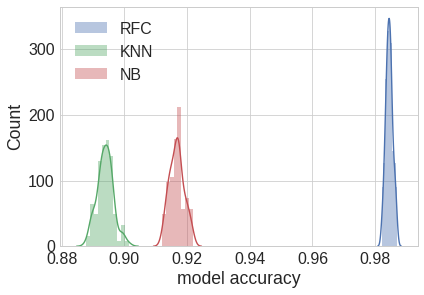

RFC: Mean 0.984493118647 	 std 0.00108106791249
KNN: Mean 0.893896734731 	 std 0.00255091773876
NB:  Mean 0.916735630116 	 std 0.00229674111456


In [84]:
sns.distplot(model_acy_rfc,label="RFC")
sns.distplot(model_acy_knn,label="KNN")
sns.distplot(model_acy_gnb, label="NB")
sns.plt.ylabel("Count")
sns.plt.xlabel("model accuracy")
sns.plt.legend(loc="best")
sns.plt.grid(True)
sns.plt.show()
print "RFC: Mean {0} \t std {1}".format(np.mean(model_acy_rfc),np.std(model_acy_rfc))
print "KNN: Mean {0} \t std {1}".format(np.mean(model_acy_knn),np.std(model_acy_knn))
print "NB:  Mean {0} \t std {1}".format(np.mean(model_acy_gnb),np.std(model_acy_gnb))

In [85]:
idx = CFS.cfs(x_train0.values, y_train0.values)

In [86]:
print idx
print x_train0[idx[:5]].keys()
print impdf[-5:]['features'].values

[ 1  8  9 13  7  4]
Index([u'tC_mean', u't_per25', u't_per75', u'f_skew', u't_slope'], dtype='object')
['t_sumvalues' 't_per75' 'tp_mean' 't_cumsumx' 'tC_mean']


In [87]:
model_acy_rfc = []
model_acy_gnb = []
model_acy_knn = []
for i in range(100):
    if i % 10 == 0:
        print i,
    X0 = shuffle(X0)
    (training_inputs,
     testing_inputs,
     training_classes,
     testing_classes) = train_test_split(X0[idx[:5]], X0['rfi'], train_size=0.7)
    
    decision_tree_classifier = RandomForestClassifier(n_jobs=-1,random_state=4)
    decision_tree_classifier.fit(training_inputs, training_classes)
    classifier_accuracy = decision_tree_classifier.score(testing_inputs, testing_classes)
    model_acy_rfc.append(classifier_accuracy)
    
    decision_tree_classifier = GaussianNB()
    decision_tree_classifier.fit(training_inputs, training_classes)
    classifier_accuracy = decision_tree_classifier.score(testing_inputs, testing_classes)
    model_acy_gnb.append(classifier_accuracy)
    
    decision_tree_classifier = KNeighborsClassifier(n_jobs=-1)
    decision_tree_classifier.fit(training_inputs, training_classes)
    classifier_accuracy = decision_tree_classifier.score(testing_inputs, testing_classes)
    model_acy_knn.append(classifier_accuracy)

del training_inputs
del testing_inputs
del training_classes
del testing_classes
del classifier_accuracy
del decision_tree_classifier

0 10 20 30 40 50 60 70 80 90


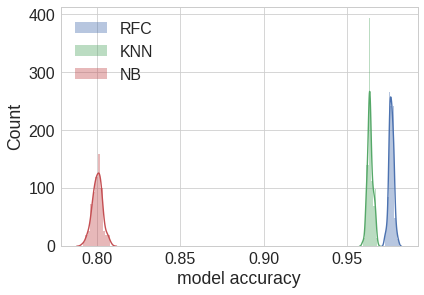

RFC: Mean 0.976411801745 	 std 0.00147241021107
KNN: Mean 0.963699739138 	 std 0.00163902788208
NB:  Mean 0.800178105604 	 std 0.00304347893507


In [88]:
sns.distplot(model_acy_rfc,label="RFC")
sns.distplot(model_acy_knn,label="KNN")
sns.distplot(model_acy_gnb, label="NB")
sns.plt.ylabel("Count")
sns.plt.xlabel("model accuracy")
sns.plt.legend(loc="best")
sns.plt.grid(True)
sns.plt.show()
print "RFC: Mean {0} \t std {1}".format(np.mean(model_acy_rfc),np.std(model_acy_rfc))
print "KNN: Mean {0} \t std {1}".format(np.mean(model_acy_knn),np.std(model_acy_knn))
print "NB:  Mean {0} \t std {1}".format(np.mean(model_acy_gnb),np.std(model_acy_gnb))

## Conclusion

To conclude on can see that the random forest classifier performs better than the KNN and the NB on all fronts.
One can see that all the features selection techniques that have been been used show that the feature importance obtained from the RFC show a better selection of the features than all the other features selection techniques used and as seen above the none of the selected features show any signs of overfitting. Moving forward the RFC is the best classifier to use for RFI detection. 

As seen in the data visualisation section there is a significant data imbalance.  This data imbalance shows that the two classes do not contain the same number of examples, does the machine learning training step carries a bias. Class imbalance can be corrected for by splitting the data 50/50 by randomly sampling from both classes. In randomly sampling from the two classes to account for the class imbalance randomly sampling the space may change the true representation of the data. Resulting in the machine learning algorithm not generalising well.

# Data Imbalancing

In [89]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import TomekLinks

In [90]:
os = TomekLinks(ratio=0.5, n_jobs=-1)
x_train_res, y_train_res = os.fit_sample(X0[names], X0['rfi'])

/data/olorato/mywork/local/lib/python2.7/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)


In [91]:
print  "Distribution of class labels before resampling {}".format(Counter(y_train0))
print  "Distribution of class labels after resampling  {}".format(Counter(y_train_res))

Distribution of class labels before resampling Counter({0: 20761, 1: 5177})
Distribution of class labels after resampling  Counter({0: 27585, 1: 7411})


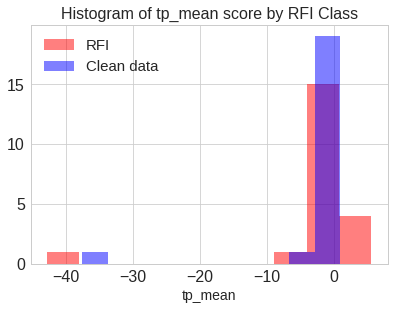

In [92]:
sns.plt.figure()
#X0[X0['rfi']==1][names[2]].plot.hist(alpha=0.5,color='red', label='RFI')
#X0[X0['rfi']==0][names[2]].plot.hist(alpha=0.5, color='blue', label='Clean data')
sns.plt.hist(x_train_res[y_train_res==1][2],alpha=0.5,color='red', label='RFI')
sns.plt.hist(x_train_res[y_train_res==0][2],alpha=0.5, color='blue', label='Clean data')
sns.plt.legend(fontsize=15)
sns.plt.title ("Histogram of "+str(names[2])+" score by RFI Class", fontsize=16)
sns.plt.xlabel(names[2], fontsize=14)
sns.plt.show()

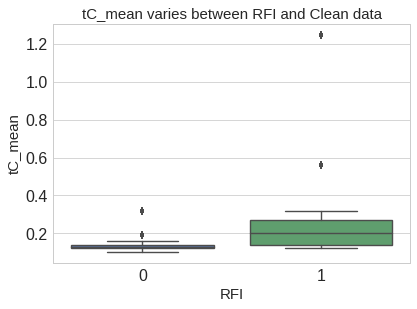

In [93]:
sns.plt.figure()
sns.boxplot(x=y_train_res,y=x_train_res[:,1])
sns.plt.title(str(names[1])+" varies between RFI and Clean data", fontsize=15)
sns.plt.xlabel("RFI",fontsize=15)
sns.plt.ylabel(str(names[1]),fontsize=15)
sns.plt.show()

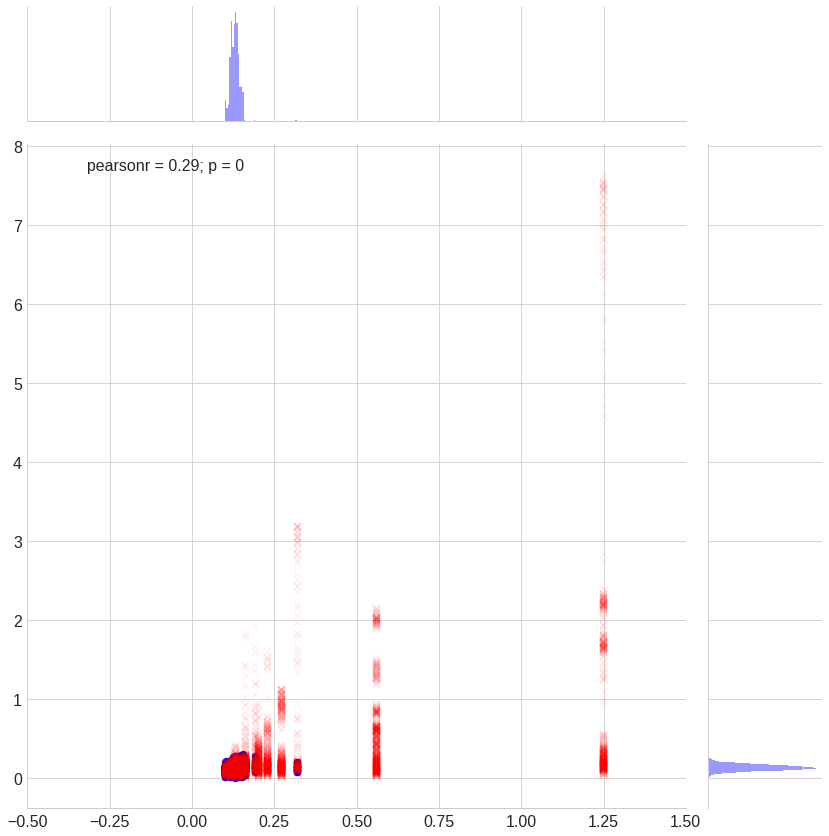

In [94]:
sns.plt.figure()
X1 = x_train_res[y_train_res==0]
g = sns.jointplot(x=X1[:,1],y=X1[:,0], color='blue', size=12,s=50)
X1 = x_train_res[y_train_res==1]
g.x = x_train_res[:,1]
g.y = x_train_res[:,0]
g.plot_joint(sns.plt.scatter, marker='x', c='r', s=50,alpha = 0.05)
#sns.jointplot(x=names[0],y=names[9],data=X1, color='red', size=12)
sns.plt.xlim(-0.5,1.5)
del X1
sns.plt.show()

In [95]:
model_accuracies = []

for i in range(100):
    if i%10 ==0:
        print i,
    (training_inputs,
     testing_inputs,
     training_classes,
     testing_classes) = train_test_split(x_train_res, y_train_res, train_size=0.7)
    
    decision_tree_classifier = RandomForestClassifier(n_jobs=-1)
    decision_tree_classifier.fit(training_inputs, training_classes)
    classifier_accuracy = decision_tree_classifier.score(testing_inputs, testing_classes)
    model_accuracies.append(classifier_accuracy)
del training_inputs
del testing_inputs
del training_classes
del testing_classes
del classifier_accuracy
del decision_tree_classifier

0 10 20 30 40 50 60 70 80 90


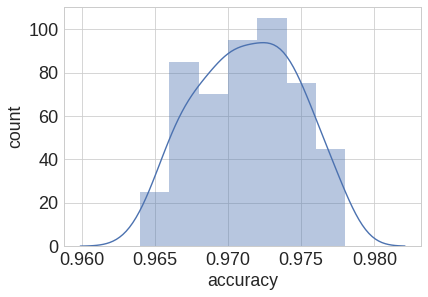

In [96]:
sns.distplot(model_accuracies)
sns.plt.xlabel("accuracy")
sns.plt.ylabel("count")
sns.plt.xticks(size=18)
sns.plt.yticks(size=18)
sns.plt.show()

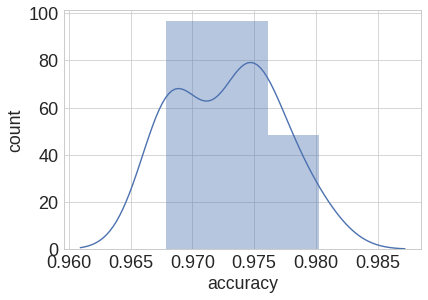

In [97]:
cv_scores = cross_val_score(RandomForestClassifier(n_jobs=-1), x_train_res, y_train_res, cv=15,)
sns.distplot(cv_scores)
sns.plt.xlabel("accuracy")
sns.plt.ylabel("count")
sns.plt.xticks(size=18)
sns.plt.yticks(size=18)
sns.plt.show()

In [98]:
x_train0, x_test0, y_train0, y_test0 = train_test_split(x_train_res
                                        ,y_train_res, test_size=0.30
                                        ,random_state=6)

In [99]:
clf_base = RandomForestClassifier(random_state = 0, n_jobs=-1)
grid = {'n_estimators': np.arange(1, 50)
        ,'criterion': ['gini', 'entropy']
        ,'max_features':['sqrt','log2']
        ,'max_depth':np.arange(1,50)
        ,'min_samples_split':np.arange(1,50)}

In [100]:
cv = StratifiedKFold(y=y_train0,shuffle=True,n_folds=10,random_state=0)
clf = RandomizedSearchCV(clf_base, grid, cv=cv,n_iter=1)
clf.fit(x_train0, y_train0)

RandomizedSearchCV(cv=sklearn.cross_validation.StratifiedKFold(labels=[0 0 ..., 0 0], n_folds=10, shuffle=True, random_state=0),
          error_score='raise',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=0, verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=1, n_jobs=1,
          param_distributions={'n_estimators': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]), 'max_features': ['sqrt', 'log2'], 'min_sampl...27, 28, 29, 30, 31, 32, 33, 34,
       35,

In [101]:
report(clf.cv_results_,"RFC")

Model with rank: 1
Mean validation score: 0.971 (std: 0.004)
Parameters: {'n_estimators': 24, 'min_samples_split': 33, 'criterion': 'gini', 'max_depth': 43, 'max_features': 'log2'}



In [102]:
clf = clf.best_estimator_

In [103]:
y_pred_prob_clf = clf.predict_proba(x_test0)
y_pred_clf = clf.predict(x_test0)

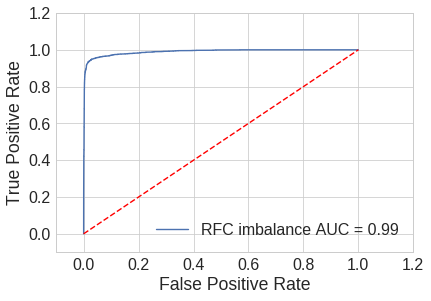

In [104]:
model_names =['RFC imbalance']
roc_plot([y_pred_prob_clf],False,model_names)
sns.plt.grid(True)
sns.plt.show()

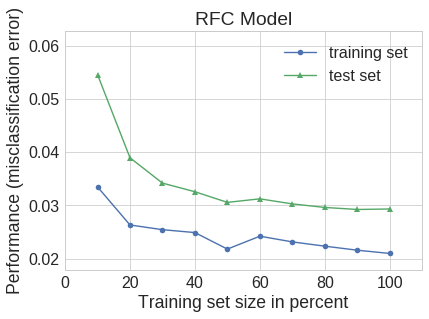

In [105]:
sns.plt.figure()
plot_learning_curves(x_train0, y_train0, x_test0, y_test0, clf
                     ,print_model=False,style="seaborn-whitegrid")
sns.plt.title('RFC Model')
sns.plt.show()

Classification Report for RFC
             precision    recall  f1-score   support

    Not RFI       0.97      0.99      0.98      8312
        RFI       0.97      0.88      0.93      2187

avg / total       0.97      0.97      0.97     10499


 The model is 97.066387 accurate


[[8260   52]
 [ 256 1931]]


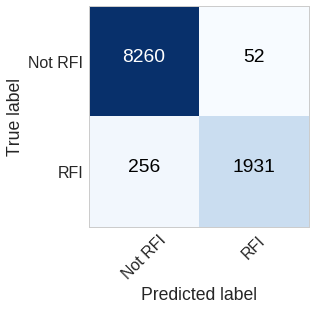

('Misclassification error rate:', 0.029)
('matthews_corrcoef: ', 0.90958515363659331)


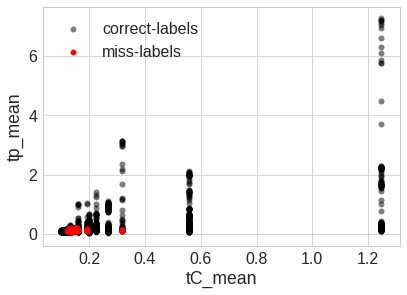

In [106]:
evaluate(y_pred_clf,'RFC')
conf_mat=confusion_matrix(y_test0,y_pred_clf)
print conf_mat
plot_confusion_matrix(conf_mat, classes=target_names,normalize=False)
sns.plt.show()
print("Misclassification error rate:",round(np.mean(y_pred_clf!=y_test0),3))
print("matthews_corrcoef: ",matthews_corrcoef(y_test0,y_pred_clf))
sns.plt.figure()
sns.plt.scatter(x_test0[:,1],x_test0[:,2],c='k',alpha=0.5,label='correct-labels')
sns.plt.scatter(x_test0[:,1][np.where(y_test0!=y_pred_clf)[0]],x_test0[:,2][np.where(y_test0!=y_pred_clf)[0]],c='r',label='miss-labels')
sns.plt.xlabel(names[1])
sns.plt.ylabel(names[2])
sns.plt.legend(loc='best')
sns.plt.show()

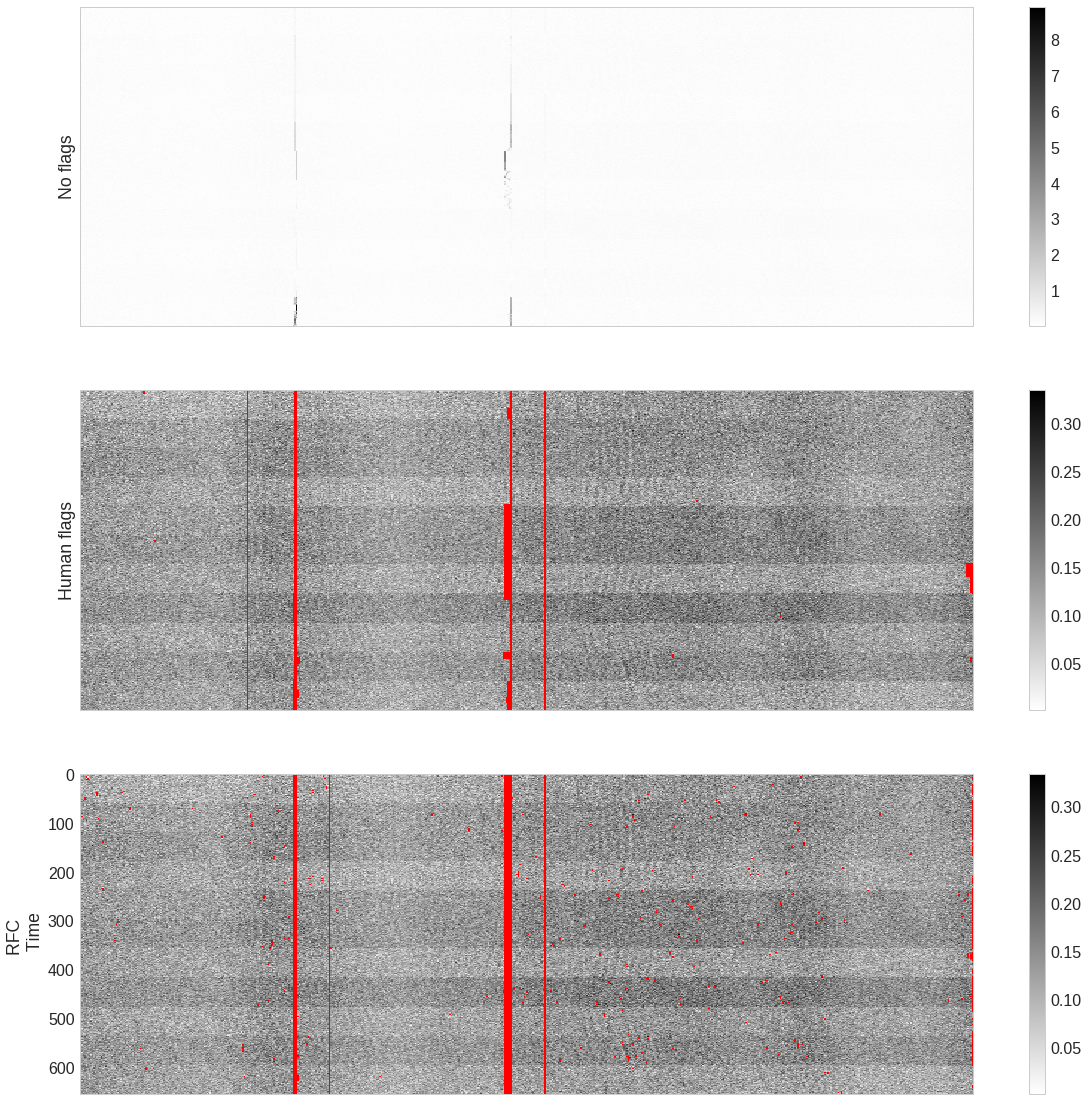

In [107]:
testVV = pd.DataFrame.from_csv('HH1333134985_pks1613-586.1822.ms_all_data_baseline0and1.csv')
#testVV = testVV.replace(to_replace=np.nan,value=0.0)
rfi_rfc =clf.predict(testVV[names])

image = np.reshape(testVV['d_p'],(len(testVV)/len(np.unique(testVV['frequency'])),len(np.unique(testVV['frequency']))), order='F' )
org_flags = np.reshape(testVV['rfi'],(len(testVV)/len(np.unique(testVV['frequency'])),len(np.unique(testVV['frequency']))), order='F')
rfc_flags = np.reshape(rfi_rfc,(len(testVV)/len(np.unique(testVV['frequency'])),len(np.unique(testVV['frequency']))), order='F')


sns.plt.figure(figsize=(20,20))
sns.plt.subplot(3,1,1)
sns.plt.imshow(image,cmap=palette,aspect ='auto')
sns.plt.grid(False)
sns.plt.colorbar()
#sns.plt.xlabel("Channels")
sns.plt.ylabel("No flags")
sns.plt.xticks([])
sns.plt.yticks([])

sns.plt.subplot(3,1,2)
sns.plt.imshow(np.ma.array(image,mask=org_flags),cmap=palette,aspect ='auto')
sns.plt.grid(False)
sns.plt.colorbar()
#sns.plt.xlabel("Channels")
sns.plt.ylabel("Human flags")
sns.plt.xticks([])
sns.plt.yticks([])


sns.plt.subplot(3,1,3)
sns.plt.imshow(np.ma.array(image,mask=rfc_flags),cmap=palette,aspect ='auto')
sns.plt.grid(False)
sns.plt.colorbar()
#sns.plt.xlabel("Channels")
sns.plt.ylabel("Time")
#sns.plt.xlabel("Channels")
sns.plt.ylabel("RFC \n Time")
sns.plt.xticks([])
#sns.plt.savefig("Results/HH/seen_HH-model_flags2.png",dpi=600)
sns.plt.show()

In [108]:
print "Old top features"
print impdf[-6:]['features'].values

Old top features
['t_var' 't_sumvalues' 't_per75' 'tp_mean' 't_cumsumx' 'tC_mean']


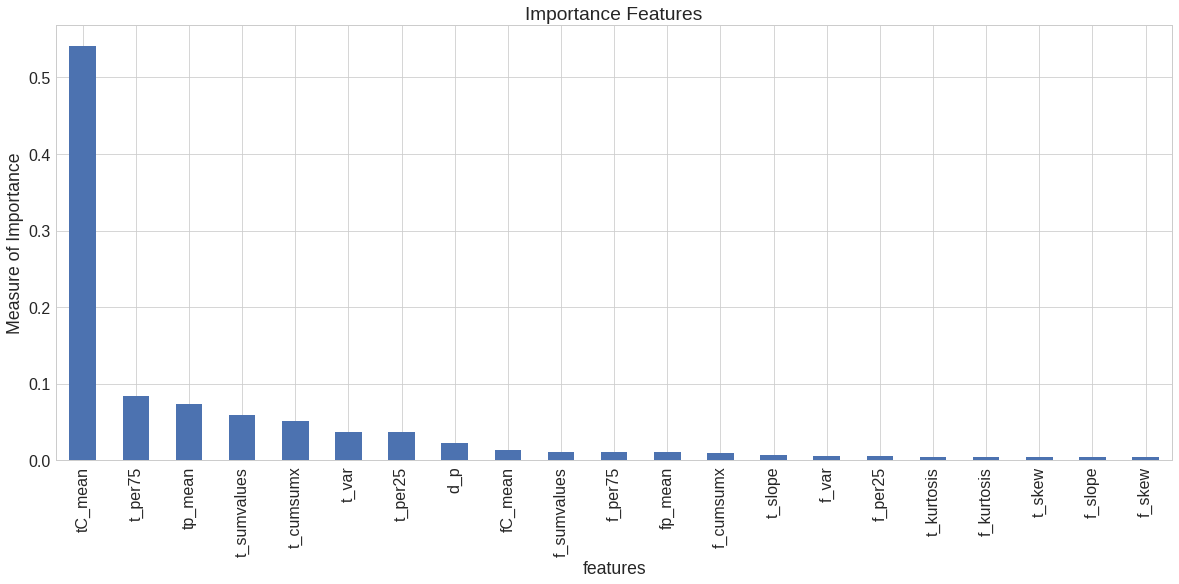

/data/olorato/mywork/lib/python2.7/site-packages/ipykernel_launcher.py:22: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


In [109]:
importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rfc.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

feature_space= []
# Print the feature ranking
impdf = []
for f in range(x_train0.shape[1]):
    feature_space.append(names[indices[f]])
    impdf.append({'features': names[indices[f]], 'importance': importances[indices[f]]})

impdf = pd.DataFrame(impdf)
impdf = impdf.sort_values(by='importance', ascending=False).reset_index(drop=True)
impdf['importance'] /= impdf['importance'].sum()
impdf.index = impdf['features']
sns.plt.figure()
impdf.plot(kind='bar', title='Importance Features', figsize=(20, 8),legend=False,fontsize=16.0)
sns.plt.ylabel("Measure of Importance")
sns.plt.grid(True)
sns.plt.show()
impdf = impdf.sort('importance')

In [110]:
print "new top features" 
print impdf[-6:]['features'].values

new top features
['t_var' 't_cumsumx' 't_sumvalues' 'tp_mean' 't_per75' 'tC_mean']


# Unsupervised Learning
### Cluster Analysis

# DBSCAN

In [111]:
from sklearn.cluster import DBSCAN


In [112]:
eps1 = 0.05
sample=10

In [113]:
for i in range(1,100,2):
    dbs = DBSCAN(eps1*i, min_samples=sample)
    dbs_preds = dbs.fit_predict(X0[impdf[-3:]['features'].values])
    print np.unique(dbs_preds),i

[-1  0  1  2  3  4  5  6  7  8  9 10] 1
[-1  0  1  2  3  4  5  6  7  8  9] 3
[-1  0  1  2  3  4  5  6  7] 5
[-1  0  1  2  3  4  5] 7
[-1  0  1  2  3  4] 9
[-1  0  1  2] 11
[-1  0  1  2] 13
[-1  0  1] 15
[-1  0  1] 17
[-1  0  1] 19
[-1  0  1] 21
[-1  0  1] 23
[-1  0  1] 25
[-1  0  1] 27
[-1  0  1] 29
[-1  0  1] 31
[-1  0  1] 33
[-1  0  1] 35
[-1  0  1] 37
[0 1] 39
[0 1] 41
[0 1] 43
[0 1] 45
[0 1] 47
[0 1] 49
[0 1] 51
[0 1] 53
[0] 55
[0] 57
[0] 59
[0] 61
[0] 63
[0] 65
[0] 67
[0] 69
[0] 71
[0] 73
[0] 75
[0] 77
[0] 79
[0] 81
[0] 83
[0] 85
[0] 87
[0] 89
[0] 91
[0] 93
[0] 95
[0] 97
[0] 99


In [114]:
dbs = DBSCAN(eps=eps1, min_samples=sample)
dbs.fit_predict(X0[impdf[-1:]['features'].values][X0.rfi == 0])
my_cmap = mpl.cm.colors.ListedColormap(sns.color_palette('Set1', len(np.unique(dbs_preds))),
                                       name='from_list', N=len(np.unique(dbs_preds)))
dbs_preds = dbs.predict(X0[impdf[-1:]['features'].values])
print np.unique(dbs_preds)
dbs_preds[dbs_preds==0]=2
print('Color palette used throughout the notebook :')
sns.palplot(sns.color_palette("Set2",len(np.unique(dbs_preds))))
sns.plt.show()

AttributeError: 'DBSCAN' object has no attribute 'predict'

In [ ]:
sns.plt.figure(figsize=(14,7))
sns.plt.scatter(y=names[0],x=names[1],data=X0,c=dbs_preds)
sns.plt.show()